In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchnet as tnt
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, CenterCrop, Scale
#import torch.nn.functional as F
from torchnet.meter import meter
from tqdm import tqdm
from matplotlib import pyplot as plt
import h5py
import math
from math import log10
import os
from os import listdir
from os.path import join
import skimage.io as io
import skimage.color as col
import skimage.transform as tr
import numpy as np
from PIL import Image

%matplotlib inline

In [289]:
class PSNRMeter(meter.Meter):
    def __init__(self):
        super(PSNRMeter, self).__init__()
        self.reset()

    def reset(self):
        self.n = 0
        self.sesum = 0.0

    def add(self, output, target):
        if not torch.is_tensor(output) and not torch.is_tensor(target):
            output = torch.from_numpy(output)
            target = torch.from_numpy(target)
        output = output.cpu()
        target = target.cpu()
        self.n += output.numel()
        self.sesum += torch.sum((output - target) ** 2)

    def value(self):
        mse = self.sesum / max(1, self.n)
        psnr = 10 * log10(1 / mse)
        return psnr
    
class PSNRMeterImage(meter.Meter):
    def __init__(self):
        super(PSNRMeterImage, self).__init__()
        self.reset()

    def reset(self):
        self.n = 0
        self.sesum = 0.0

    def add(self, output, target):
        if not torch.is_tensor(output) and not torch.is_tensor(target):
            output = torch.from_numpy(output)
            target = torch.from_numpy(target)
        output = output.cpu()
        target = target.cpu()
        self.n += output.numel()
        self.sesum += torch.sum((output - target) ** 2)

    def value(self):
        mse = self.sesum / max(1, self.n)
        psnr = 10 * log10((256 ** 2) / mse)
        return psnr

In [4]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in
               ['.png', '.jpg', '.jpeg', '.JPG', '.JPEG', '.PNG', '.bmp'])

def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def input_transform(crop_size, upscale_factor):
    return Compose([
        CenterCrop(crop_size),
        Scale(crop_size // upscale_factor)
    ])


def target_transform(crop_size):
    return Compose([
        CenterCrop(crop_size)
    ])
'''
def lr_transform(image, upscale_factor):
    return tr.resize(image, (image.shape[0] // upscale_factor,image.shape[1] // upscale_factor))
'''

class DatasetFromFolderY(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderY, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        image, _, _ = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        target, _, _ = Image.open(self.target_filenames[index]).convert('YCbCr').split()

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)
    
class DatasetFromFolderCb(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderCb, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        _, image, _ = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        _, target, _ = Image.open(self.target_filenames[index]).convert('YCbCr').split()

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)
    
class DatasetFromFolderCr(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderCr, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        _, _, image = Image.open(self.image_filenames[index]).convert('YCbCr').split()
        _, _, target = Image.open(self.target_filenames[index]).convert('YCbCr').split()

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)


def generate_dataset(data_type, upscale_factor, size):
    images_name = [x for x in listdir(data_type) if is_image_file(x)]
    crop_size = calculate_valid_crop_size(size, upscale_factor)
    lr_transform = input_transform(crop_size, upscale_factor)
    hr_transform = target_transform(crop_size)

    root = 'data/' + data_type
    if not os.path.exists(root):
        os.makedirs(root)
    path = root + '/SRF_' + str(upscale_factor)
    if not os.path.exists(path):
        os.makedirs(path)
    image_path = path + '/data'
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    target_path = path + '/target'
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    for image_name in tqdm(images_name, desc='generate ' + data_type + ' dataset with upscale factor = '
            + str(upscale_factor)):
        image = Image.open(data_type + '/' + image_name)
        target = image.copy()
        image = lr_transform(image)
        target = hr_transform(target)

        image.save(image_path + '/' + image_name)
        target.save(target_path + '/' + image_name)

UPSCALE_FACTOR = 3

generate_dataset(data_type='Train', upscale_factor=UPSCALE_FACTOR, size = 128)
generate_dataset(data_type='Test/Set14', upscale_factor=UPSCALE_FACTOR, size = 128)
generate_dataset(data_type='Test/Set5', upscale_factor=UPSCALE_FACTOR, size = 256)

/usr/local/lib/python3.7/site-packages/torchvision/transforms/transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
generate Train dataset with upscale factor = 3: 100%|██████████| 91/91 [00:00<00:00, 735.95it/s]
generate Test/Set14 dataset with upscale factor = 3: 100%|██████████| 14/14 [00:00<00:00, 343.38it/s]
generate Test/Set5 dataset with upscale factor = 3: 100%|██████████| 5/5 [00:00<00:00, 328.23it/s]


In [251]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 1 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = torch.sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x
    
class NetRGB(nn.Module):
    def __init__(self, upscale_factor):
        super(NetRGB, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 3 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = torch.sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x

In [189]:
def processorY(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_Y(data)
    loss = criterion(output, target)

    return loss, output

def processorCb(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_Cb(data)
    loss = criterion(output, target)

    return loss, output

def processorCr(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_Cr(data)
    loss = criterion(output, target)

    return loss, output

def on_sample(state):
    state['sample'].append(state['train'])


def reset_meters():
    meter_psnr.reset()
    meter_loss.reset()


def on_forward(state):
    meter_psnr.add(state['output'].data, state['sample'][1])
    meter_loss.add(state['loss'].data)


def on_start_epoch(state):
    reset_meters()
    state['iterator'] = tqdm(state['iterator'])


def on_end_epochY(state):
    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorY, val_loader)
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()
    
def on_end_epochCb(state):
    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorCb, val_loader)
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()
    
def on_end_epochCr(state):

    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorCr, val_loader)
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()


UPSCALE_FACTOR = 3
NUM_EPOCHS = 150

train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderY('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderY('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)

model_Y = Net(upscale_factor=UPSCALE_FACTOR)
criterion = nn.MSELoss()
if torch.cuda.is_available():
    model_Y = model_Y.cuda()
    criterion = criterion.cuda()

print('# parameters:', sum(param.numel() for param in model_Y.parameters()))

optimizer = optim.Adam(model_Y.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[30, 80, 120], gamma=0.1)

engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()

engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochY

engine.train(processorY, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)


 17%|█▋        | 2/12 [00:00<00:00, 17.93it/s]

# parameters: 22729


 25%|██▌       | 3/12 [00:00<00:00, 21.36it/s]

[Epoch 1] Train Loss: 0.0461 (PSNR: 13.24 db)
[Epoch 1] Val Loss: 0.0273 (PSNR: 15.62 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.29it/s]

[Epoch 2] Train Loss: 0.0155 (PSNR: 18.00 db)
[Epoch 2] Val Loss: 0.0125 (PSNR: 19.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.78it/s]

[Epoch 3] Train Loss: 0.0101 (PSNR: 19.85 db)
[Epoch 3] Val Loss: 0.0094 (PSNR: 20.20 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.41it/s]

[Epoch 4] Train Loss: 0.0068 (PSNR: 21.56 db)
[Epoch 4] Val Loss: 0.0070 (PSNR: 21.44 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.91it/s]

[Epoch 5] Train Loss: 0.0057 (PSNR: 22.39 db)
[Epoch 5] Val Loss: 0.0060 (PSNR: 22.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.40it/s]

[Epoch 6] Train Loss: 0.0052 (PSNR: 22.93 db)
[Epoch 6] Val Loss: 0.0059 (PSNR: 22.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.73it/s]

[Epoch 7] Train Loss: 0.0045 (PSNR: 23.35 db)
[Epoch 7] Val Loss: 0.0051 (PSNR: 22.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.56it/s]

[Epoch 8] Train Loss: 0.0042 (PSNR: 23.66 db)
[Epoch 8] Val Loss: 0.0048 (PSNR: 23.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.61it/s]

[Epoch 9] Train Loss: 0.0044 (PSNR: 23.62 db)
[Epoch 9] Val Loss: 0.0048 (PSNR: 23.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.70it/s]

[Epoch 10] Train Loss: 0.0040 (PSNR: 23.89 db)
[Epoch 10] Val Loss: 0.0045 (PSNR: 23.34 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.82it/s]

[Epoch 11] Train Loss: 0.0039 (PSNR: 24.07 db)
[Epoch 11] Val Loss: 0.0041 (PSNR: 23.73 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.65it/s]

[Epoch 12] Train Loss: 0.0036 (PSNR: 24.37 db)
[Epoch 12] Val Loss: 0.0043 (PSNR: 23.59 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.61it/s]

[Epoch 13] Train Loss: 0.0035 (PSNR: 24.75 db)
[Epoch 13] Val Loss: 0.0037 (PSNR: 24.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.61it/s]

[Epoch 14] Train Loss: 0.0049 (PSNR: 23.12 db)
[Epoch 14] Val Loss: 0.0093 (PSNR: 20.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.68it/s]

[Epoch 15] Train Loss: 0.0077 (PSNR: 21.26 db)
[Epoch 15] Val Loss: 0.0111 (PSNR: 19.55 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.12it/s]

[Epoch 16] Train Loss: 0.0059 (PSNR: 22.29 db)
[Epoch 16] Val Loss: 0.0044 (PSNR: 23.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.70it/s]

[Epoch 17] Train Loss: 0.0040 (PSNR: 24.01 db)
[Epoch 17] Val Loss: 0.0041 (PSNR: 23.75 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.60it/s]

[Epoch 18] Train Loss: 0.0038 (PSNR: 24.37 db)
[Epoch 18] Val Loss: 0.0054 (PSNR: 22.55 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.55it/s]

[Epoch 19] Train Loss: 0.0042 (PSNR: 23.87 db)
[Epoch 19] Val Loss: 0.0050 (PSNR: 22.92 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.03it/s]

[Epoch 20] Train Loss: 0.0050 (PSNR: 22.88 db)
[Epoch 20] Val Loss: 0.0047 (PSNR: 23.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.10it/s]

[Epoch 21] Train Loss: 0.0038 (PSNR: 24.38 db)
[Epoch 21] Val Loss: 0.0037 (PSNR: 24.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

[Epoch 22] Train Loss: 0.0032 (PSNR: 24.91 db)
[Epoch 22] Val Loss: 0.0038 (PSNR: 24.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.64it/s]

[Epoch 23] Train Loss: 0.0031 (PSNR: 25.00 db)
[Epoch 23] Val Loss: 0.0034 (PSNR: 24.56 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.85it/s]

[Epoch 24] Train Loss: 0.0031 (PSNR: 25.21 db)
[Epoch 24] Val Loss: 0.0033 (PSNR: 24.67 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.90it/s]

[Epoch 25] Train Loss: 0.0029 (PSNR: 25.56 db)
[Epoch 25] Val Loss: 0.0033 (PSNR: 24.66 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.59it/s]

[Epoch 26] Train Loss: 0.0028 (PSNR: 25.51 db)
[Epoch 26] Val Loss: 0.0032 (PSNR: 24.82 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.77it/s]

[Epoch 27] Train Loss: 0.0028 (PSNR: 25.49 db)
[Epoch 27] Val Loss: 0.0031 (PSNR: 24.90 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.35it/s]

[Epoch 28] Train Loss: 0.0026 (PSNR: 25.81 db)
[Epoch 28] Val Loss: 0.0030 (PSNR: 25.04 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.83it/s]

[Epoch 29] Train Loss: 0.0029 (PSNR: 25.73 db)
[Epoch 29] Val Loss: 0.0030 (PSNR: 25.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.56it/s]

[Epoch 30] Train Loss: 0.0025 (PSNR: 25.93 db)
[Epoch 30] Val Loss: 0.0030 (PSNR: 25.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.51it/s]

[Epoch 31] Train Loss: 0.0027 (PSNR: 26.00 db)
[Epoch 31] Val Loss: 0.0030 (PSNR: 25.12 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.87it/s]

[Epoch 32] Train Loss: 0.0025 (PSNR: 26.02 db)
[Epoch 32] Val Loss: 0.0030 (PSNR: 25.13 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.59it/s]

[Epoch 33] Train Loss: 0.0024 (PSNR: 26.02 db)
[Epoch 33] Val Loss: 0.0030 (PSNR: 25.13 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.58it/s]

[Epoch 34] Train Loss: 0.0024 (PSNR: 26.03 db)
[Epoch 34] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.50it/s]

[Epoch 35] Train Loss: 0.0026 (PSNR: 26.03 db)
[Epoch 35] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.24it/s]

[Epoch 36] Train Loss: 0.0025 (PSNR: 26.04 db)
[Epoch 36] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.59it/s]

[Epoch 37] Train Loss: 0.0024 (PSNR: 26.04 db)
[Epoch 37] Val Loss: 0.0030 (PSNR: 25.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.55it/s]

[Epoch 38] Train Loss: 0.0025 (PSNR: 26.04 db)
[Epoch 38] Val Loss: 0.0030 (PSNR: 25.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.16it/s]

[Epoch 39] Train Loss: 0.0025 (PSNR: 26.05 db)
[Epoch 39] Val Loss: 0.0030 (PSNR: 25.15 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.45it/s]

[Epoch 40] Train Loss: 0.0025 (PSNR: 26.05 db)
[Epoch 40] Val Loss: 0.0029 (PSNR: 25.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.03it/s]

[Epoch 41] Train Loss: 0.0024 (PSNR: 26.06 db)
[Epoch 41] Val Loss: 0.0029 (PSNR: 25.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.37it/s]

[Epoch 42] Train Loss: 0.0024 (PSNR: 26.06 db)
[Epoch 42] Val Loss: 0.0029 (PSNR: 25.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.72it/s]

[Epoch 43] Train Loss: 0.0024 (PSNR: 26.06 db)
[Epoch 43] Val Loss: 0.0029 (PSNR: 25.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.52it/s]

[Epoch 44] Train Loss: 0.0024 (PSNR: 26.07 db)
[Epoch 44] Val Loss: 0.0029 (PSNR: 25.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.86it/s]

[Epoch 45] Train Loss: 0.0024 (PSNR: 26.07 db)
[Epoch 45] Val Loss: 0.0029 (PSNR: 25.17 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 46] Train Loss: 0.0026 (PSNR: 26.08 db)
[Epoch 46] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.40it/s]

[Epoch 47] Train Loss: 0.0026 (PSNR: 26.08 db)
[Epoch 47] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.55it/s]

[Epoch 48] Train Loss: 0.0026 (PSNR: 26.08 db)
[Epoch 48] Val Loss: 0.0029 (PSNR: 25.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.23it/s]

[Epoch 49] Train Loss: 0.0024 (PSNR: 26.08 db)
[Epoch 49] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.44it/s]

[Epoch 50] Train Loss: 0.0024 (PSNR: 26.09 db)
[Epoch 50] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.35it/s]

[Epoch 51] Train Loss: 0.0024 (PSNR: 26.09 db)
[Epoch 51] Val Loss: 0.0029 (PSNR: 25.19 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 52] Train Loss: 0.0024 (PSNR: 26.09 db)
[Epoch 52] Val Loss: 0.0029 (PSNR: 25.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.09it/s]

[Epoch 53] Train Loss: 0.0025 (PSNR: 26.10 db)
[Epoch 53] Val Loss: 0.0029 (PSNR: 25.20 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 54] Train Loss: 0.0024 (PSNR: 26.10 db)
[Epoch 54] Val Loss: 0.0029 (PSNR: 25.20 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.18it/s]

[Epoch 55] Train Loss: 0.0024 (PSNR: 26.11 db)
[Epoch 55] Val Loss: 0.0029 (PSNR: 25.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.23it/s]

[Epoch 56] Train Loss: 0.0024 (PSNR: 26.11 db)
[Epoch 56] Val Loss: 0.0029 (PSNR: 25.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.72it/s]

[Epoch 57] Train Loss: 0.0024 (PSNR: 26.11 db)
[Epoch 57] Val Loss: 0.0029 (PSNR: 25.22 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 58] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 58] Val Loss: 0.0029 (PSNR: 25.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.01it/s]

[Epoch 59] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 59] Val Loss: 0.0029 (PSNR: 25.22 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 60] Train Loss: 0.0025 (PSNR: 26.12 db)
[Epoch 60] Val Loss: 0.0029 (PSNR: 25.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.31it/s]

[Epoch 61] Train Loss: 0.0024 (PSNR: 26.12 db)
[Epoch 61] Val Loss: 0.0029 (PSNR: 25.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.92it/s]

[Epoch 62] Train Loss: 0.0024 (PSNR: 26.13 db)
[Epoch 62] Val Loss: 0.0029 (PSNR: 25.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.75it/s]

[Epoch 63] Train Loss: 0.0024 (PSNR: 26.13 db)
[Epoch 63] Val Loss: 0.0029 (PSNR: 25.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.74it/s]

[Epoch 64] Train Loss: 0.0024 (PSNR: 26.13 db)
[Epoch 64] Val Loss: 0.0029 (PSNR: 25.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.27it/s]

[Epoch 65] Train Loss: 0.0025 (PSNR: 26.14 db)
[Epoch 65] Val Loss: 0.0029 (PSNR: 25.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.17it/s]

[Epoch 66] Train Loss: 0.0024 (PSNR: 26.14 db)
[Epoch 66] Val Loss: 0.0029 (PSNR: 25.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.32it/s]

[Epoch 67] Train Loss: 0.0024 (PSNR: 26.15 db)
[Epoch 67] Val Loss: 0.0029 (PSNR: 25.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.65it/s]

[Epoch 68] Train Loss: 0.0023 (PSNR: 26.15 db)
[Epoch 68] Val Loss: 0.0029 (PSNR: 25.25 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.21it/s]

[Epoch 69] Train Loss: 0.0024 (PSNR: 26.15 db)
[Epoch 69] Val Loss: 0.0029 (PSNR: 25.25 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 70] Train Loss: 0.0024 (PSNR: 26.15 db)
[Epoch 70] Val Loss: 0.0029 (PSNR: 25.25 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.85it/s]

[Epoch 71] Train Loss: 0.0025 (PSNR: 26.16 db)
[Epoch 71] Val Loss: 0.0029 (PSNR: 25.25 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.68it/s]

[Epoch 72] Train Loss: 0.0024 (PSNR: 26.16 db)
[Epoch 72] Val Loss: 0.0029 (PSNR: 25.26 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.77it/s]

[Epoch 73] Train Loss: 0.0024 (PSNR: 26.16 db)
[Epoch 73] Val Loss: 0.0029 (PSNR: 25.26 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.55it/s]

[Epoch 74] Train Loss: 0.0024 (PSNR: 26.17 db)
[Epoch 74] Val Loss: 0.0029 (PSNR: 25.26 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 75] Train Loss: 0.0024 (PSNR: 26.17 db)
[Epoch 75] Val Loss: 0.0029 (PSNR: 25.26 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.40it/s]

[Epoch 76] Train Loss: 0.0024 (PSNR: 26.17 db)
[Epoch 76] Val Loss: 0.0029 (PSNR: 25.27 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.86it/s]

[Epoch 77] Train Loss: 0.0024 (PSNR: 26.18 db)
[Epoch 77] Val Loss: 0.0029 (PSNR: 25.27 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.82it/s]

[Epoch 78] Train Loss: 0.0024 (PSNR: 26.18 db)
[Epoch 78] Val Loss: 0.0029 (PSNR: 25.27 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.50it/s]

[Epoch 79] Train Loss: 0.0025 (PSNR: 26.18 db)
[Epoch 79] Val Loss: 0.0029 (PSNR: 25.27 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.52it/s]

[Epoch 80] Train Loss: 0.0025 (PSNR: 26.19 db)
[Epoch 80] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.65it/s]

[Epoch 81] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 81] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.69it/s]

[Epoch 82] Train Loss: 0.0024 (PSNR: 26.19 db)
[Epoch 82] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.75it/s]

[Epoch 83] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 83] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.57it/s]

[Epoch 84] Train Loss: 0.0024 (PSNR: 26.19 db)
[Epoch 84] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.60it/s]

[Epoch 85] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 85] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.44it/s]

[Epoch 86] Train Loss: 0.0025 (PSNR: 26.19 db)
[Epoch 86] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.65it/s]

[Epoch 87] Train Loss: 0.0024 (PSNR: 26.19 db)
[Epoch 87] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.34it/s]

[Epoch 88] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 88] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.54it/s]

[Epoch 89] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 89] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.66it/s]

[Epoch 90] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 90] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

[Epoch 91] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 91] Val Loss: 0.0029 (PSNR: 25.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.44it/s]

[Epoch 92] Train Loss: 0.0027 (PSNR: 26.19 db)
[Epoch 92] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.53it/s]

[Epoch 93] Train Loss: 0.0025 (PSNR: 26.19 db)
[Epoch 93] Val Loss: 0.0029 (PSNR: 25.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.01it/s]

[Epoch 94] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 94] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

[Epoch 95] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 95] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.59it/s]

[Epoch 96] Train Loss: 0.0023 (PSNR: 26.19 db)
[Epoch 96] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.32it/s]

[Epoch 97] Train Loss: 0.0024 (PSNR: 26.19 db)
[Epoch 97] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.59it/s]

[Epoch 98] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 98] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.83it/s]

[Epoch 99] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 99] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.64it/s]

[Epoch 100] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 100] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.67it/s]

[Epoch 101] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 101] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.89it/s]

[Epoch 102] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 102] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.50it/s]

[Epoch 103] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 103] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.66it/s]

[Epoch 104] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 104] Val Loss: 0.0029 (PSNR: 25.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.77it/s]

[Epoch 105] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 105] Val Loss: 0.0029 (PSNR: 25.29 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.94it/s]

[Epoch 106] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 106] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.70it/s]

[Epoch 107] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 107] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.52it/s]

[Epoch 108] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 108] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.73it/s]

[Epoch 109] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 109] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.74it/s]

[Epoch 110] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 110] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.41it/s]

[Epoch 111] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 111] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.54it/s]

[Epoch 112] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 112] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.51it/s]

[Epoch 113] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 113] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.41it/s]

[Epoch 114] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 114] Val Loss: 0.0029 (PSNR: 25.29 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.02it/s]

[Epoch 115] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 115] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.50it/s]

[Epoch 116] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 116] Val Loss: 0.0029 (PSNR: 25.29 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.04it/s]

[Epoch 117] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 117] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.45it/s]

[Epoch 118] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 118] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 19.82it/s]

[Epoch 119] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 119] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.55it/s]

[Epoch 120] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 120] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.56it/s]

[Epoch 121] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 121] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.52it/s]

[Epoch 122] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 122] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.62it/s]

[Epoch 123] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 123] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.98it/s]

[Epoch 124] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 124] Val Loss: 0.0029 (PSNR: 25.29 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.93it/s]

[Epoch 125] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 125] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.77it/s]

[Epoch 126] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 126] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.62it/s]

[Epoch 127] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 127] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.54it/s]

[Epoch 128] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 128] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.57it/s]

[Epoch 129] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 129] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.38it/s]

[Epoch 130] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 130] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.66it/s]

[Epoch 131] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 131] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.64it/s]

[Epoch 132] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 132] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.57it/s]

[Epoch 133] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 133] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.72it/s]

[Epoch 134] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 134] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.03it/s]

[Epoch 135] Train Loss: 0.0026 (PSNR: 26.20 db)
[Epoch 135] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.38it/s]

[Epoch 136] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 136] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.84it/s]

[Epoch 137] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 137] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.41it/s]

[Epoch 138] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 138] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.72it/s]

[Epoch 139] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 139] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.68it/s]

[Epoch 140] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 140] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.74it/s]

[Epoch 141] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 141] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.64it/s]

[Epoch 142] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 142] Val Loss: 0.0029 (PSNR: 25.29 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 143] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 143] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.47it/s]

[Epoch 144] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 144] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.27it/s]

[Epoch 145] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 145] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.58it/s]

[Epoch 146] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 146] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.61it/s]

[Epoch 147] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 147] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.98it/s]

[Epoch 148] Train Loss: 0.0024 (PSNR: 26.20 db)
[Epoch 148] Val Loss: 0.0029 (PSNR: 25.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.52it/s]

[Epoch 149] Train Loss: 0.0025 (PSNR: 26.20 db)
[Epoch 149] Val Loss: 0.0029 (PSNR: 25.29 db)


100%|██████████| 12/12 [00:00<00:00, 22.53it/s]

[Epoch 150] Train Loss: 0.0023 (PSNR: 26.20 db)
[Epoch 150] Val Loss: 0.0029 (PSNR: 25.29 db)


{'network': <function __main__.processorY(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 20.78it/s],
 'maxepoch': 150,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 1e-05
     weight_decay: 0
 ),
 'epoch': 150,
 't': 1800,
 'train': True,
 'sample': [tensor([[[[0.3725, 0.5098, 0.4353,  ..., 0.1765, 0.1725, 0.1608],
            [0.3373, 0.4745, 0.4824,  ..., 0.1725, 0.1569, 0.1451],
            [0.3725, 0.4118, 0.5176,  ..., 0.1686, 0.1569, 0.1725],
            ...,
            [0.4549, 0.4706, 0.3373,  ..., 0.2863, 0.2863, 0.2745],
            [0.4431, 0.4314, 0.4000,  ..., 0.1647, 0.2667, 0.2627],
            [0.4235, 0.4157, 0.3843,  ..., 0.1608, 0.1725, 0.2471]]],
  
  
          [[[0.6157, 0.6314, 0.6471,  ..., 0.5294, 0.5216, 0.5216],
            [0.6157, 0.6275, 0.6235,  ..., 0.5686, 0.5412, 0.5294],
            [0.6118, 0.6196, 0.6314,  ..., 0.5608, 0.5843, 0.5961],
            ...

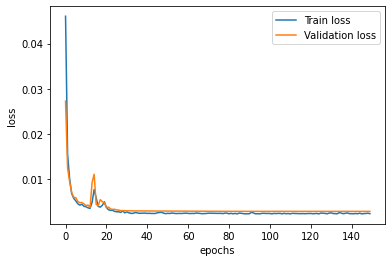

In [190]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

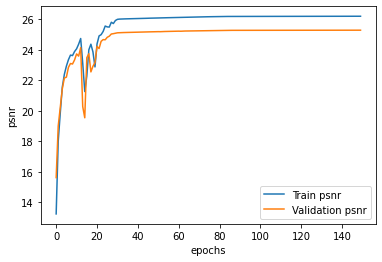

In [191]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

In [173]:
train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderCb('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderCb('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)
model_Cb = Net(upscale_factor=UPSCALE_FACTOR)
if torch.cuda.is_available():
    model_Cb = model_Cb.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adam(model_Cb.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()
engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochCb

engine.train(processorCb, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)

 25%|██▌       | 3/12 [00:00<00:00, 20.78it/s]

[Epoch 1] Train Loss: 0.0418 (PSNR: 13.67 db)
[Epoch 1] Val Loss: 0.0147 (PSNR: 18.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.05it/s]

[Epoch 2] Train Loss: 0.0085 (PSNR: 20.64 db)
[Epoch 2] Val Loss: 0.0076 (PSNR: 21.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.55it/s]

[Epoch 3] Train Loss: 0.0054 (PSNR: 22.76 db)
[Epoch 3] Val Loss: 0.0018 (PSNR: 27.42 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.23it/s]

[Epoch 4] Train Loss: 0.0025 (PSNR: 25.94 db)
[Epoch 4] Val Loss: 0.0010 (PSNR: 29.78 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.35it/s]

[Epoch 5] Train Loss: 0.0013 (PSNR: 28.67 db)
[Epoch 5] Val Loss: 0.0006 (PSNR: 31.79 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.16it/s]

[Epoch 6] Train Loss: 0.0009 (PSNR: 30.66 db)
[Epoch 6] Val Loss: 0.0005 (PSNR: 32.65 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.15it/s]

[Epoch 7] Train Loss: 0.0008 (PSNR: 30.96 db)
[Epoch 7] Val Loss: 0.0007 (PSNR: 31.45 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.59it/s]

[Epoch 8] Train Loss: 0.0008 (PSNR: 30.94 db)
[Epoch 8] Val Loss: 0.0004 (PSNR: 33.69 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.29it/s]

[Epoch 9] Train Loss: 0.0007 (PSNR: 31.53 db)
[Epoch 9] Val Loss: 0.0004 (PSNR: 34.02 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.46it/s]

[Epoch 10] Train Loss: 0.0006 (PSNR: 31.89 db)
[Epoch 10] Val Loss: 0.0004 (PSNR: 34.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.31it/s]

[Epoch 11] Train Loss: 0.0007 (PSNR: 31.84 db)
[Epoch 11] Val Loss: 0.0006 (PSNR: 32.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.54it/s]

[Epoch 12] Train Loss: 0.0007 (PSNR: 31.62 db)
[Epoch 12] Val Loss: 0.0005 (PSNR: 32.85 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.51it/s]

[Epoch 13] Train Loss: 0.0006 (PSNR: 31.96 db)
[Epoch 13] Val Loss: 0.0004 (PSNR: 33.78 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.65it/s]

[Epoch 14] Train Loss: 0.0009 (PSNR: 30.47 db)
[Epoch 14] Val Loss: 0.0012 (PSNR: 29.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.51it/s]

[Epoch 15] Train Loss: 0.0011 (PSNR: 29.65 db)
[Epoch 15] Val Loss: 0.0008 (PSNR: 31.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.48it/s]

[Epoch 16] Train Loss: 0.0010 (PSNR: 29.92 db)
[Epoch 16] Val Loss: 0.0007 (PSNR: 31.55 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.55it/s]

[Epoch 17] Train Loss: 0.0006 (PSNR: 32.09 db)
[Epoch 17] Val Loss: 0.0009 (PSNR: 30.67 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.51it/s]

[Epoch 18] Train Loss: 0.0008 (PSNR: 31.41 db)
[Epoch 18] Val Loss: 0.0009 (PSNR: 30.55 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.43it/s]

[Epoch 19] Train Loss: 0.0006 (PSNR: 32.36 db)
[Epoch 19] Val Loss: 0.0004 (PSNR: 34.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.47it/s]

[Epoch 20] Train Loss: 0.0004 (PSNR: 34.11 db)
[Epoch 20] Val Loss: 0.0003 (PSNR: 35.77 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.73it/s]

[Epoch 21] Train Loss: 0.0003 (PSNR: 34.65 db)
[Epoch 21] Val Loss: 0.0003 (PSNR: 35.45 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.28it/s]

[Epoch 22] Train Loss: 0.0004 (PSNR: 34.71 db)
[Epoch 22] Val Loss: 0.0003 (PSNR: 35.67 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.00it/s]

[Epoch 23] Train Loss: 0.0003 (PSNR: 35.04 db)
[Epoch 23] Val Loss: 0.0002 (PSNR: 36.18 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.92it/s]

[Epoch 24] Train Loss: 0.0003 (PSNR: 35.37 db)
[Epoch 24] Val Loss: 0.0002 (PSNR: 36.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.03it/s]

[Epoch 25] Train Loss: 0.0003 (PSNR: 35.11 db)
[Epoch 25] Val Loss: 0.0003 (PSNR: 34.54 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.06it/s]

[Epoch 26] Train Loss: 0.0003 (PSNR: 35.04 db)
[Epoch 26] Val Loss: 0.0002 (PSNR: 35.91 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.57it/s]

[Epoch 27] Train Loss: 0.0004 (PSNR: 33.68 db)
[Epoch 27] Val Loss: 0.0008 (PSNR: 30.85 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.20it/s]

[Epoch 28] Train Loss: 0.0007 (PSNR: 31.66 db)
[Epoch 28] Val Loss: 0.0006 (PSNR: 31.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.54it/s]

[Epoch 29] Train Loss: 0.0008 (PSNR: 30.98 db)
[Epoch 29] Val Loss: 0.0007 (PSNR: 31.31 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.64it/s]

[Epoch 30] Train Loss: 0.0005 (PSNR: 32.89 db)
[Epoch 30] Val Loss: 0.0002 (PSNR: 36.57 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.64it/s]

[Epoch 31] Train Loss: 0.0003 (PSNR: 35.89 db)
[Epoch 31] Val Loss: 0.0002 (PSNR: 36.63 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.69it/s]

[Epoch 32] Train Loss: 0.0002 (PSNR: 36.04 db)
[Epoch 32] Val Loss: 0.0002 (PSNR: 36.80 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.50it/s]

[Epoch 33] Train Loss: 0.0002 (PSNR: 36.12 db)
[Epoch 33] Val Loss: 0.0002 (PSNR: 36.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.07it/s]

[Epoch 34] Train Loss: 0.0002 (PSNR: 36.20 db)
[Epoch 34] Val Loss: 0.0002 (PSNR: 36.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.39it/s]

[Epoch 35] Train Loss: 0.0002 (PSNR: 36.24 db)
[Epoch 35] Val Loss: 0.0002 (PSNR: 36.86 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.49it/s]

[Epoch 36] Train Loss: 0.0002 (PSNR: 36.29 db)
[Epoch 36] Val Loss: 0.0002 (PSNR: 36.77 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.53it/s]

[Epoch 37] Train Loss: 0.0002 (PSNR: 36.34 db)
[Epoch 37] Val Loss: 0.0002 (PSNR: 37.00 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.37it/s]

[Epoch 38] Train Loss: 0.0002 (PSNR: 36.38 db)
[Epoch 38] Val Loss: 0.0002 (PSNR: 37.00 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.89it/s]

[Epoch 39] Train Loss: 0.0002 (PSNR: 36.42 db)
[Epoch 39] Val Loss: 0.0002 (PSNR: 37.02 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.40it/s]

[Epoch 40] Train Loss: 0.0002 (PSNR: 36.46 db)
[Epoch 40] Val Loss: 0.0002 (PSNR: 36.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.14it/s]

[Epoch 41] Train Loss: 0.0002 (PSNR: 36.48 db)
[Epoch 41] Val Loss: 0.0002 (PSNR: 36.96 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.54it/s]

[Epoch 42] Train Loss: 0.0002 (PSNR: 36.51 db)
[Epoch 42] Val Loss: 0.0002 (PSNR: 37.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.55it/s]

[Epoch 43] Train Loss: 0.0002 (PSNR: 36.54 db)
[Epoch 43] Val Loss: 0.0002 (PSNR: 37.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.48it/s]

[Epoch 44] Train Loss: 0.0002 (PSNR: 36.57 db)
[Epoch 44] Val Loss: 0.0002 (PSNR: 37.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.18it/s]

[Epoch 45] Train Loss: 0.0002 (PSNR: 36.58 db)
[Epoch 45] Val Loss: 0.0002 (PSNR: 37.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.37it/s]

[Epoch 46] Train Loss: 0.0002 (PSNR: 36.62 db)
[Epoch 46] Val Loss: 0.0002 (PSNR: 36.97 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.50it/s]

[Epoch 47] Train Loss: 0.0002 (PSNR: 36.64 db)
[Epoch 47] Val Loss: 0.0002 (PSNR: 37.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.43it/s]

[Epoch 48] Train Loss: 0.0002 (PSNR: 36.68 db)
[Epoch 48] Val Loss: 0.0002 (PSNR: 37.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.46it/s]

[Epoch 49] Train Loss: 0.0002 (PSNR: 36.71 db)
[Epoch 49] Val Loss: 0.0002 (PSNR: 36.93 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.98it/s]

[Epoch 50] Train Loss: 0.0002 (PSNR: 36.71 db)
[Epoch 50] Val Loss: 0.0002 (PSNR: 37.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.58it/s]

[Epoch 51] Train Loss: 0.0002 (PSNR: 36.76 db)
[Epoch 51] Val Loss: 0.0002 (PSNR: 37.11 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.47it/s]

[Epoch 52] Train Loss: 0.0002 (PSNR: 36.78 db)
[Epoch 52] Val Loss: 0.0002 (PSNR: 36.98 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.42it/s]

[Epoch 53] Train Loss: 0.0002 (PSNR: 36.76 db)
[Epoch 53] Val Loss: 0.0002 (PSNR: 37.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.51it/s]

[Epoch 54] Train Loss: 0.0002 (PSNR: 36.82 db)
[Epoch 54] Val Loss: 0.0002 (PSNR: 37.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.34it/s]

[Epoch 55] Train Loss: 0.0002 (PSNR: 36.85 db)
[Epoch 55] Val Loss: 0.0002 (PSNR: 37.19 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.47it/s]

[Epoch 56] Train Loss: 0.0002 (PSNR: 36.86 db)
[Epoch 56] Val Loss: 0.0002 (PSNR: 37.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.39it/s]

[Epoch 57] Train Loss: 0.0002 (PSNR: 36.90 db)
[Epoch 57] Val Loss: 0.0002 (PSNR: 37.22 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.11it/s]

[Epoch 58] Train Loss: 0.0002 (PSNR: 36.93 db)
[Epoch 58] Val Loss: 0.0002 (PSNR: 37.21 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.53it/s]

[Epoch 59] Train Loss: 0.0002 (PSNR: 36.94 db)
[Epoch 59] Val Loss: 0.0002 (PSNR: 37.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.41it/s]

[Epoch 60] Train Loss: 0.0002 (PSNR: 36.96 db)
[Epoch 60] Val Loss: 0.0002 (PSNR: 37.27 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.40it/s]

[Epoch 61] Train Loss: 0.0002 (PSNR: 36.99 db)
[Epoch 61] Val Loss: 0.0002 (PSNR: 37.25 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.90it/s]

[Epoch 62] Train Loss: 0.0002 (PSNR: 37.01 db)
[Epoch 62] Val Loss: 0.0002 (PSNR: 37.26 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.58it/s]

[Epoch 63] Train Loss: 0.0002 (PSNR: 37.04 db)
[Epoch 63] Val Loss: 0.0002 (PSNR: 37.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.41it/s]

[Epoch 64] Train Loss: 0.0002 (PSNR: 37.06 db)
[Epoch 64] Val Loss: 0.0002 (PSNR: 37.29 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.98it/s]

[Epoch 65] Train Loss: 0.0002 (PSNR: 37.08 db)
[Epoch 65] Val Loss: 0.0002 (PSNR: 37.30 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.46it/s]

[Epoch 66] Train Loss: 0.0002 (PSNR: 37.09 db)
[Epoch 66] Val Loss: 0.0002 (PSNR: 37.32 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.46it/s]

[Epoch 67] Train Loss: 0.0002 (PSNR: 37.12 db)
[Epoch 67] Val Loss: 0.0002 (PSNR: 37.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.75it/s]

[Epoch 68] Train Loss: 0.0002 (PSNR: 37.15 db)
[Epoch 68] Val Loss: 0.0002 (PSNR: 37.34 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.06it/s]

[Epoch 69] Train Loss: 0.0002 (PSNR: 37.16 db)
[Epoch 69] Val Loss: 0.0002 (PSNR: 37.35 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.42it/s]

[Epoch 70] Train Loss: 0.0002 (PSNR: 37.18 db)
[Epoch 70] Val Loss: 0.0002 (PSNR: 37.36 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.42it/s]

[Epoch 71] Train Loss: 0.0002 (PSNR: 37.21 db)
[Epoch 71] Val Loss: 0.0002 (PSNR: 37.37 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.43it/s]

[Epoch 72] Train Loss: 0.0002 (PSNR: 37.21 db)
[Epoch 72] Val Loss: 0.0002 (PSNR: 37.37 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.48it/s]

[Epoch 73] Train Loss: 0.0002 (PSNR: 37.23 db)
[Epoch 73] Val Loss: 0.0002 (PSNR: 37.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.30it/s]

[Epoch 74] Train Loss: 0.0002 (PSNR: 37.22 db)
[Epoch 74] Val Loss: 0.0002 (PSNR: 37.38 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.49it/s]

[Epoch 75] Train Loss: 0.0002 (PSNR: 37.28 db)
[Epoch 75] Val Loss: 0.0002 (PSNR: 37.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.30it/s]

[Epoch 76] Train Loss: 0.0002 (PSNR: 37.30 db)
[Epoch 76] Val Loss: 0.0002 (PSNR: 37.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.42it/s]

[Epoch 77] Train Loss: 0.0002 (PSNR: 37.32 db)
[Epoch 77] Val Loss: 0.0002 (PSNR: 37.39 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.36it/s]

[Epoch 78] Train Loss: 0.0002 (PSNR: 37.34 db)
[Epoch 78] Val Loss: 0.0002 (PSNR: 37.44 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.55it/s]

[Epoch 79] Train Loss: 0.0002 (PSNR: 37.36 db)
[Epoch 79] Val Loss: 0.0002 (PSNR: 37.44 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.56it/s]

[Epoch 80] Train Loss: 0.0002 (PSNR: 37.38 db)
[Epoch 80] Val Loss: 0.0002 (PSNR: 37.44 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.96it/s]

[Epoch 81] Train Loss: 0.0002 (PSNR: 37.40 db)
[Epoch 81] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.47it/s]

[Epoch 82] Train Loss: 0.0002 (PSNR: 37.40 db)
[Epoch 82] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.34it/s]

[Epoch 83] Train Loss: 0.0002 (PSNR: 37.41 db)
[Epoch 83] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.31it/s]

[Epoch 84] Train Loss: 0.0002 (PSNR: 37.41 db)
[Epoch 84] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.39it/s]

[Epoch 85] Train Loss: 0.0002 (PSNR: 37.41 db)
[Epoch 85] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.45it/s]

[Epoch 86] Train Loss: 0.0002 (PSNR: 37.41 db)
[Epoch 86] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.30it/s]

[Epoch 87] Train Loss: 0.0002 (PSNR: 37.41 db)
[Epoch 87] Val Loss: 0.0002 (PSNR: 37.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.43it/s]

[Epoch 88] Train Loss: 0.0002 (PSNR: 37.41 db)
[Epoch 88] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.11it/s]

[Epoch 89] Train Loss: 0.0002 (PSNR: 37.42 db)
[Epoch 89] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.50it/s]

[Epoch 90] Train Loss: 0.0002 (PSNR: 37.42 db)
[Epoch 90] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.50it/s]

[Epoch 91] Train Loss: 0.0002 (PSNR: 37.42 db)
[Epoch 91] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.25it/s]

[Epoch 92] Train Loss: 0.0002 (PSNR: 37.42 db)
[Epoch 92] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.32it/s]

[Epoch 93] Train Loss: 0.0002 (PSNR: 37.42 db)
[Epoch 93] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.37it/s]

[Epoch 94] Train Loss: 0.0002 (PSNR: 37.43 db)
[Epoch 94] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.33it/s]

[Epoch 95] Train Loss: 0.0002 (PSNR: 37.43 db)
[Epoch 95] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.47it/s]

[Epoch 96] Train Loss: 0.0002 (PSNR: 37.43 db)
[Epoch 96] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.45it/s]

[Epoch 97] Train Loss: 0.0002 (PSNR: 37.43 db)
[Epoch 97] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.32it/s]

[Epoch 98] Train Loss: 0.0002 (PSNR: 37.44 db)
[Epoch 98] Val Loss: 0.0002 (PSNR: 37.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.16it/s]

[Epoch 99] Train Loss: 0.0002 (PSNR: 37.44 db)
[Epoch 99] Val Loss: 0.0002 (PSNR: 37.48 db)


100%|██████████| 12/12 [00:00<00:00, 23.22it/s]

[Epoch 100] Train Loss: 0.0002 (PSNR: 37.44 db)
[Epoch 100] Val Loss: 0.0002 (PSNR: 37.47 db)


{'network': <function __main__.processorCb(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 21.55it/s],
 'maxepoch': 100,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 0.0001
     weight_decay: 0
 ),
 'epoch': 100,
 't': 1200,
 'train': True,
 'sample': [tensor([[[[0.4431, 0.4471, 0.4510,  ..., 0.4392, 0.4431, 0.4471],
            [0.4549, 0.4471, 0.4510,  ..., 0.4392, 0.4431, 0.4471],
            [0.4588, 0.4471, 0.4510,  ..., 0.4431, 0.4392, 0.4431],
            ...,
            [0.4392, 0.4392, 0.4392,  ..., 0.4667, 0.4667, 0.4667],
            [0.4392, 0.4353, 0.4353,  ..., 0.4667, 0.4667, 0.4667],
            [0.4353, 0.4392, 0.4353,  ..., 0.4627, 0.4627, 0.4627]]],
  
  
          [[[0.3569, 0.3529, 0.3451,  ..., 0.4784, 0.4824, 0.4824],
            [0.3569, 0.3529, 0.3529,  ..., 0.4824, 0.4824, 0.4863],
            [0.3608, 0.3569, 0.3490,  ..., 0.4824, 0.4824, 0.4784],
            .

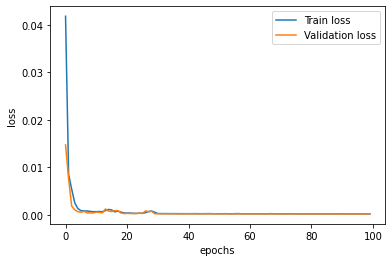

In [174]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

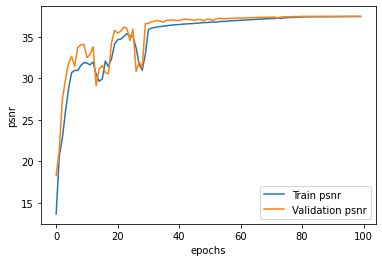

In [175]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

In [161]:
train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderCr('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderCr('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)
model_Cr = Net(upscale_factor=UPSCALE_FACTOR)
if torch.cuda.is_available():
    model_Cr = model_Cr.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adam(model_Cr.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[30, 100], gamma=0.1)
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()
engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochCr

engine.train(processorCr, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)

 25%|██▌       | 3/12 [00:00<00:00, 21.74it/s]

[Epoch 1] Train Loss: 0.0444 (PSNR: 13.33 db)
[Epoch 1] Val Loss: 0.0162 (PSNR: 17.83 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.08it/s]

[Epoch 2] Train Loss: 0.0110 (PSNR: 19.44 db)
[Epoch 2] Val Loss: 0.0046 (PSNR: 23.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

[Epoch 3] Train Loss: 0.0034 (PSNR: 24.57 db)
[Epoch 3] Val Loss: 0.0035 (PSNR: 24.50 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.48it/s]

[Epoch 4] Train Loss: 0.0025 (PSNR: 25.80 db)
[Epoch 4] Val Loss: 0.0023 (PSNR: 26.24 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.33it/s]

[Epoch 5] Train Loss: 0.0017 (PSNR: 27.65 db)
[Epoch 5] Val Loss: 0.0012 (PSNR: 28.89 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.41it/s]

[Epoch 6] Train Loss: 0.0012 (PSNR: 29.40 db)
[Epoch 6] Val Loss: 0.0009 (PSNR: 30.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.44it/s]

[Epoch 7] Train Loss: 0.0011 (PSNR: 29.81 db)
[Epoch 7] Val Loss: 0.0022 (PSNR: 26.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.64it/s]

[Epoch 8] Train Loss: 0.0013 (PSNR: 29.29 db)
[Epoch 8] Val Loss: 0.0014 (PSNR: 28.36 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.07it/s]

[Epoch 9] Train Loss: 0.0018 (PSNR: 27.24 db)
[Epoch 9] Val Loss: 0.0009 (PSNR: 30.05 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.44it/s]

[Epoch 10] Train Loss: 0.0011 (PSNR: 29.40 db)
[Epoch 10] Val Loss: 0.0013 (PSNR: 28.72 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.63it/s]

[Epoch 11] Train Loss: 0.0008 (PSNR: 31.06 db)
[Epoch 11] Val Loss: 0.0008 (PSNR: 30.60 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.94it/s]

[Epoch 12] Train Loss: 0.0007 (PSNR: 31.64 db)
[Epoch 12] Val Loss: 0.0007 (PSNR: 31.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.56it/s]

[Epoch 13] Train Loss: 0.0006 (PSNR: 32.10 db)
[Epoch 13] Val Loss: 0.0007 (PSNR: 31.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.25it/s]

[Epoch 14] Train Loss: 0.0007 (PSNR: 31.85 db)
[Epoch 14] Val Loss: 0.0007 (PSNR: 31.08 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.11it/s]

[Epoch 15] Train Loss: 0.0006 (PSNR: 31.86 db)
[Epoch 15] Val Loss: 0.0006 (PSNR: 31.78 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.32it/s]

[Epoch 16] Train Loss: 0.0007 (PSNR: 31.48 db)
[Epoch 16] Val Loss: 0.0006 (PSNR: 31.73 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.85it/s]

[Epoch 17] Train Loss: 0.0006 (PSNR: 32.62 db)
[Epoch 17] Val Loss: 0.0006 (PSNR: 32.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.30it/s]

[Epoch 18] Train Loss: 0.0006 (PSNR: 32.26 db)
[Epoch 18] Val Loss: 0.0006 (PSNR: 32.14 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.83it/s]

[Epoch 19] Train Loss: 0.0006 (PSNR: 32.40 db)
[Epoch 19] Val Loss: 0.0006 (PSNR: 32.03 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.95it/s]

[Epoch 20] Train Loss: 0.0008 (PSNR: 30.75 db)
[Epoch 20] Val Loss: 0.0007 (PSNR: 31.28 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.61it/s]

[Epoch 21] Train Loss: 0.0008 (PSNR: 31.34 db)
[Epoch 21] Val Loss: 0.0007 (PSNR: 31.12 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.18it/s]

[Epoch 22] Train Loss: 0.0008 (PSNR: 30.70 db)
[Epoch 22] Val Loss: 0.0011 (PSNR: 29.45 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.26it/s]

[Epoch 23] Train Loss: 0.0007 (PSNR: 31.87 db)
[Epoch 23] Val Loss: 0.0006 (PSNR: 31.96 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.17it/s]

[Epoch 24] Train Loss: 0.0004 (PSNR: 33.57 db)
[Epoch 24] Val Loss: 0.0007 (PSNR: 31.39 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.24it/s]

[Epoch 25] Train Loss: 0.0004 (PSNR: 33.58 db)
[Epoch 25] Val Loss: 0.0005 (PSNR: 32.78 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.32it/s]

[Epoch 26] Train Loss: 0.0005 (PSNR: 33.51 db)
[Epoch 26] Val Loss: 0.0006 (PSNR: 31.71 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.98it/s]

[Epoch 27] Train Loss: 0.0008 (PSNR: 30.92 db)
[Epoch 27] Val Loss: 0.0021 (PSNR: 26.62 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.35it/s]

[Epoch 28] Train Loss: 0.0009 (PSNR: 30.52 db)
[Epoch 28] Val Loss: 0.0005 (PSNR: 32.84 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.41it/s]

[Epoch 29] Train Loss: 0.0008 (PSNR: 31.43 db)
[Epoch 29] Val Loss: 0.0009 (PSNR: 30.54 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.58it/s]

[Epoch 30] Train Loss: 0.0013 (PSNR: 29.08 db)
[Epoch 30] Val Loss: 0.0007 (PSNR: 31.54 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.49it/s]

[Epoch 31] Train Loss: 0.0006 (PSNR: 32.43 db)
[Epoch 31] Val Loss: 0.0006 (PSNR: 32.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.30it/s]

[Epoch 32] Train Loss: 0.0004 (PSNR: 33.51 db)
[Epoch 32] Val Loss: 0.0005 (PSNR: 32.53 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.58it/s]

[Epoch 33] Train Loss: 0.0004 (PSNR: 34.14 db)
[Epoch 33] Val Loss: 0.0005 (PSNR: 33.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.54it/s]

[Epoch 34] Train Loss: 0.0003 (PSNR: 34.60 db)
[Epoch 34] Val Loss: 0.0004 (PSNR: 33.25 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.84it/s]

[Epoch 35] Train Loss: 0.0003 (PSNR: 34.94 db)
[Epoch 35] Val Loss: 0.0004 (PSNR: 33.35 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.90it/s]

[Epoch 36] Train Loss: 0.0003 (PSNR: 35.04 db)
[Epoch 36] Val Loss: 0.0004 (PSNR: 33.37 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.43it/s]

[Epoch 37] Train Loss: 0.0003 (PSNR: 35.08 db)
[Epoch 37] Val Loss: 0.0004 (PSNR: 33.37 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.57it/s]

[Epoch 38] Train Loss: 0.0003 (PSNR: 35.16 db)
[Epoch 38] Val Loss: 0.0004 (PSNR: 33.39 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.33it/s]

[Epoch 39] Train Loss: 0.0003 (PSNR: 35.14 db)
[Epoch 39] Val Loss: 0.0004 (PSNR: 33.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.38it/s]

[Epoch 40] Train Loss: 0.0003 (PSNR: 35.24 db)
[Epoch 40] Val Loss: 0.0004 (PSNR: 33.39 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.64it/s]

[Epoch 41] Train Loss: 0.0003 (PSNR: 35.27 db)
[Epoch 41] Val Loss: 0.0004 (PSNR: 33.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.47it/s]

[Epoch 42] Train Loss: 0.0003 (PSNR: 35.44 db)
[Epoch 42] Val Loss: 0.0004 (PSNR: 33.49 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.55it/s]

[Epoch 43] Train Loss: 0.0003 (PSNR: 35.41 db)
[Epoch 43] Val Loss: 0.0004 (PSNR: 33.44 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.28it/s]

[Epoch 44] Train Loss: 0.0003 (PSNR: 35.33 db)
[Epoch 44] Val Loss: 0.0004 (PSNR: 33.64 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.45it/s]

[Epoch 45] Train Loss: 0.0003 (PSNR: 35.68 db)
[Epoch 45] Val Loss: 0.0004 (PSNR: 33.65 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.54it/s]

[Epoch 46] Train Loss: 0.0003 (PSNR: 35.68 db)
[Epoch 46] Val Loss: 0.0004 (PSNR: 33.68 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.54it/s]

[Epoch 47] Train Loss: 0.0003 (PSNR: 35.79 db)
[Epoch 47] Val Loss: 0.0004 (PSNR: 33.75 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.65it/s]

[Epoch 48] Train Loss: 0.0003 (PSNR: 35.68 db)
[Epoch 48] Val Loss: 0.0004 (PSNR: 33.76 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.10it/s]

[Epoch 49] Train Loss: 0.0003 (PSNR: 35.84 db)
[Epoch 49] Val Loss: 0.0004 (PSNR: 33.81 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.58it/s]

[Epoch 50] Train Loss: 0.0003 (PSNR: 35.81 db)
[Epoch 50] Val Loss: 0.0004 (PSNR: 33.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.74it/s]

[Epoch 51] Train Loss: 0.0003 (PSNR: 36.05 db)
[Epoch 51] Val Loss: 0.0004 (PSNR: 33.88 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.37it/s]

[Epoch 52] Train Loss: 0.0003 (PSNR: 35.94 db)
[Epoch 52] Val Loss: 0.0004 (PSNR: 33.81 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.90it/s]

[Epoch 53] Train Loss: 0.0002 (PSNR: 36.18 db)
[Epoch 53] Val Loss: 0.0004 (PSNR: 33.92 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.41it/s]

[Epoch 54] Train Loss: 0.0002 (PSNR: 36.21 db)
[Epoch 54] Val Loss: 0.0004 (PSNR: 33.83 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.41it/s]

[Epoch 55] Train Loss: 0.0002 (PSNR: 36.22 db)
[Epoch 55] Val Loss: 0.0004 (PSNR: 33.96 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.01it/s]

[Epoch 56] Train Loss: 0.0002 (PSNR: 36.37 db)
[Epoch 56] Val Loss: 0.0004 (PSNR: 33.92 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.50it/s]

[Epoch 57] Train Loss: 0.0002 (PSNR: 36.39 db)
[Epoch 57] Val Loss: 0.0004 (PSNR: 34.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.83it/s]

[Epoch 58] Train Loss: 0.0002 (PSNR: 36.43 db)
[Epoch 58] Val Loss: 0.0004 (PSNR: 33.76 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.17it/s]

[Epoch 59] Train Loss: 0.0002 (PSNR: 36.14 db)
[Epoch 59] Val Loss: 0.0004 (PSNR: 33.75 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.85it/s]

[Epoch 60] Train Loss: 0.0002 (PSNR: 36.27 db)
[Epoch 60] Val Loss: 0.0004 (PSNR: 33.81 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.76it/s]

[Epoch 61] Train Loss: 0.0002 (PSNR: 36.29 db)
[Epoch 61] Val Loss: 0.0004 (PSNR: 34.01 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.74it/s]

[Epoch 62] Train Loss: 0.0002 (PSNR: 36.25 db)
[Epoch 62] Val Loss: 0.0004 (PSNR: 33.83 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.16it/s]

[Epoch 63] Train Loss: 0.0002 (PSNR: 36.56 db)
[Epoch 63] Val Loss: 0.0004 (PSNR: 34.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.65it/s]

[Epoch 64] Train Loss: 0.0002 (PSNR: 36.74 db)
[Epoch 64] Val Loss: 0.0004 (PSNR: 34.06 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.35it/s]

[Epoch 65] Train Loss: 0.0002 (PSNR: 36.49 db)
[Epoch 65] Val Loss: 0.0004 (PSNR: 33.91 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.93it/s]

[Epoch 66] Train Loss: 0.0002 (PSNR: 36.40 db)
[Epoch 66] Val Loss: 0.0004 (PSNR: 34.10 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.40it/s]

[Epoch 67] Train Loss: 0.0002 (PSNR: 36.66 db)
[Epoch 67] Val Loss: 0.0004 (PSNR: 34.17 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.98it/s]

[Epoch 68] Train Loss: 0.0002 (PSNR: 36.94 db)
[Epoch 68] Val Loss: 0.0004 (PSNR: 34.23 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.76it/s]

[Epoch 69] Train Loss: 0.0002 (PSNR: 36.88 db)
[Epoch 69] Val Loss: 0.0004 (PSNR: 34.07 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.29it/s]

[Epoch 70] Train Loss: 0.0002 (PSNR: 36.97 db)
[Epoch 70] Val Loss: 0.0003 (PSNR: 34.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.39it/s]

[Epoch 71] Train Loss: 0.0002 (PSNR: 37.07 db)
[Epoch 71] Val Loss: 0.0003 (PSNR: 34.29 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.65it/s]

[Epoch 72] Train Loss: 0.0002 (PSNR: 36.96 db)
[Epoch 72] Val Loss: 0.0003 (PSNR: 34.31 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.23it/s]

[Epoch 73] Train Loss: 0.0002 (PSNR: 36.90 db)
[Epoch 73] Val Loss: 0.0004 (PSNR: 34.16 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.89it/s]

[Epoch 74] Train Loss: 0.0002 (PSNR: 36.98 db)
[Epoch 74] Val Loss: 0.0004 (PSNR: 34.09 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.82it/s]

[Epoch 75] Train Loss: 0.0002 (PSNR: 36.91 db)
[Epoch 75] Val Loss: 0.0003 (PSNR: 34.36 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.25it/s]

[Epoch 76] Train Loss: 0.0002 (PSNR: 37.21 db)
[Epoch 76] Val Loss: 0.0003 (PSNR: 34.35 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.06it/s]

[Epoch 77] Train Loss: 0.0002 (PSNR: 37.36 db)
[Epoch 77] Val Loss: 0.0003 (PSNR: 34.33 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.53it/s]

[Epoch 78] Train Loss: 0.0002 (PSNR: 37.34 db)
[Epoch 78] Val Loss: 0.0003 (PSNR: 34.40 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.28it/s]

[Epoch 79] Train Loss: 0.0002 (PSNR: 37.37 db)
[Epoch 79] Val Loss: 0.0003 (PSNR: 34.30 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.45it/s]

[Epoch 80] Train Loss: 0.0002 (PSNR: 37.36 db)
[Epoch 80] Val Loss: 0.0003 (PSNR: 34.43 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.01it/s]

[Epoch 81] Train Loss: 0.0002 (PSNR: 37.47 db)
[Epoch 81] Val Loss: 0.0003 (PSNR: 34.42 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.63it/s]

[Epoch 82] Train Loss: 0.0002 (PSNR: 37.48 db)
[Epoch 82] Val Loss: 0.0003 (PSNR: 34.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.39it/s]

[Epoch 83] Train Loss: 0.0002 (PSNR: 37.53 db)
[Epoch 83] Val Loss: 0.0003 (PSNR: 34.41 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.95it/s]

[Epoch 84] Train Loss: 0.0002 (PSNR: 37.48 db)
[Epoch 84] Val Loss: 0.0003 (PSNR: 34.48 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.97it/s]

[Epoch 85] Train Loss: 0.0002 (PSNR: 37.55 db)
[Epoch 85] Val Loss: 0.0003 (PSNR: 34.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.31it/s]

[Epoch 86] Train Loss: 0.0002 (PSNR: 37.54 db)
[Epoch 86] Val Loss: 0.0003 (PSNR: 34.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.38it/s]

[Epoch 87] Train Loss: 0.0002 (PSNR: 37.50 db)
[Epoch 87] Val Loss: 0.0003 (PSNR: 34.47 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.70it/s]

[Epoch 88] Train Loss: 0.0002 (PSNR: 37.58 db)
[Epoch 88] Val Loss: 0.0003 (PSNR: 34.46 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.24it/s]

[Epoch 89] Train Loss: 0.0002 (PSNR: 37.75 db)
[Epoch 89] Val Loss: 0.0003 (PSNR: 34.52 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.87it/s]

[Epoch 90] Train Loss: 0.0002 (PSNR: 37.76 db)
[Epoch 90] Val Loss: 0.0003 (PSNR: 34.51 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.72it/s]

[Epoch 91] Train Loss: 0.0002 (PSNR: 37.76 db)
[Epoch 91] Val Loss: 0.0003 (PSNR: 34.52 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.23it/s]

[Epoch 92] Train Loss: 0.0002 (PSNR: 37.80 db)
[Epoch 92] Val Loss: 0.0003 (PSNR: 34.57 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.81it/s]

[Epoch 93] Train Loss: 0.0002 (PSNR: 37.87 db)
[Epoch 93] Val Loss: 0.0003 (PSNR: 34.57 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.18it/s]

[Epoch 94] Train Loss: 0.0002 (PSNR: 37.91 db)
[Epoch 94] Val Loss: 0.0003 (PSNR: 34.57 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.23it/s]

[Epoch 95] Train Loss: 0.0002 (PSNR: 37.94 db)
[Epoch 95] Val Loss: 0.0003 (PSNR: 34.58 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.38it/s]

[Epoch 96] Train Loss: 0.0002 (PSNR: 37.86 db)
[Epoch 96] Val Loss: 0.0003 (PSNR: 34.57 db)


 25%|██▌       | 3/12 [00:00<00:00, 20.62it/s]

[Epoch 97] Train Loss: 0.0002 (PSNR: 37.96 db)
[Epoch 97] Val Loss: 0.0003 (PSNR: 34.60 db)


 25%|██▌       | 3/12 [00:00<00:00, 22.26it/s]

[Epoch 98] Train Loss: 0.0002 (PSNR: 37.91 db)
[Epoch 98] Val Loss: 0.0003 (PSNR: 34.61 db)


 25%|██▌       | 3/12 [00:00<00:00, 21.37it/s]

[Epoch 99] Train Loss: 0.0002 (PSNR: 38.04 db)
[Epoch 99] Val Loss: 0.0003 (PSNR: 34.55 db)


100%|██████████| 12/12 [00:00<00:00, 22.06it/s]

[Epoch 100] Train Loss: 0.0002 (PSNR: 37.96 db)
[Epoch 100] Val Loss: 0.0003 (PSNR: 34.61 db)


{'network': <function __main__.processorCr(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 20.49it/s],
 'maxepoch': 100,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 0.0001
     weight_decay: 0
 ),
 'epoch': 100,
 't': 1200,
 'train': True,
 'sample': [tensor([[[[0.5020, 0.4941, 0.5059,  ..., 0.4980, 0.4980, 0.4980],
            [0.5059, 0.4980, 0.5333,  ..., 0.4980, 0.4980, 0.4980],
            [0.5059, 0.5176, 0.5686,  ..., 0.4941, 0.4980, 0.5020],
            ...,
            [0.4863, 0.4784, 0.4824,  ..., 0.4824, 0.4824, 0.4863],
            [0.4863, 0.4902, 0.4824,  ..., 0.4902, 0.4824, 0.4824],
            [0.4980, 0.4980, 0.4980,  ..., 0.4980, 0.4980, 0.4980]]],
  
  
          [[[0.5765, 0.5765, 0.5686,  ..., 0.5725, 0.5647, 0.5529],
            [0.5686, 0.5686, 0.5725,  ..., 0.5765, 0.5647, 0.5569],
            [0.5647, 0.5647, 0.5686,  ..., 0.5725, 0.5647, 0.5569],
            .

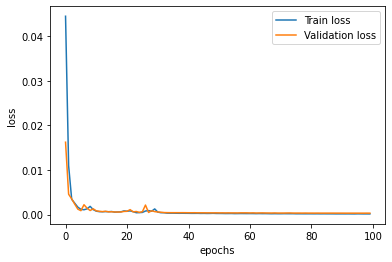

In [162]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

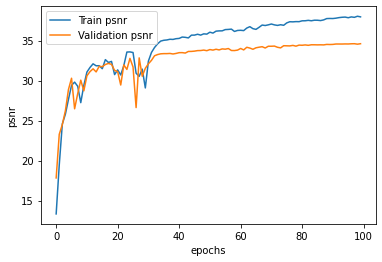

In [163]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

In [219]:
class DatasetFromFolderRGB(Dataset):
    def __init__(self, dataset_dir, upscale_factor, input_transform=None, target_transform=None):
        super(DatasetFromFolderRGB, self).__init__()
        self.image_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/data'
        self.target_dir = dataset_dir + '/SRF_' + str(upscale_factor) + '/target'
        self.image_filenames = [join(self.image_dir, x) for x in listdir(self.image_dir) if is_image_file(x)]
        self.target_filenames = [join(self.target_dir, x) for x in listdir(self.target_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        #image = col.rgb2ycbcr(io.imread(self.image_filenames[index]))[:,:,0]
        #target = col.rgb2ycbcr(io.imread(self.target_filenames[index]))[:,:,0]
        image = Image.open(self.image_filenames[index]).convert('RGB')
        target = Image.open(self.target_filenames[index]).convert('RGB')

        #return transforms.ToTensor()(image), transforms.ToTensor()(target)
        if self.input_transform:
            image = self.input_transform(image)
        if self.target_transform:
            target = self.target_transform(target)

        return image, target

    def __len__(self):
        return len(self.image_filenames)

In [303]:
model_RGB = NetRGB(upscale_factor=UPSCALE_FACTOR)

def processorRGB(sample):
    data, target, training = sample
    data = Variable(data)
    target = Variable(target)
    if torch.cuda.is_available():
        data = data.cuda()
        target = target.cuda()

    output = model_RGB(data)
    loss = criterion(output, target)

    return loss, output

def on_end_epochRGB(state):
    
    train_loss.append(meter_loss.value()[0])
    train_psnr.append(meter_psnr.value())
    
    print('[Epoch %d] Train Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))

    reset_meters()

    engine.test(processorRGB, val_loader)
    val_loss.append(meter_loss.value()[0])
    val_psnr.append(meter_psnr.value())

    print('[Epoch %d] Val Loss: %.4f (PSNR: %.2f db)' % (
        state['epoch'], meter_loss.value()[0], meter_psnr.value()))
    scheduler.step()

NUM_EPOCHS = 250    

train_loss = []
train_psnr = []
val_loss = []
val_psnr = []

train_set = DatasetFromFolderRGB('data/Train', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                  target_transform=transforms.ToTensor())
val_set = DatasetFromFolderRGB('data/Test/Set14', upscale_factor=UPSCALE_FACTOR, input_transform=transforms.ToTensor(),
                                target_transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, num_workers=0, batch_size=8, shuffle=False)
model_RGB = NetRGB(upscale_factor=UPSCALE_FACTOR)
if torch.cuda.is_available():
    model_RGB = model_RGB.cuda()
    criterion = criterion.cuda()
optimizer = optim.Adam(model_RGB.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[50, 150], gamma=0.5)
engine = Engine()
meter_loss = tnt.meter.AverageValueMeter()
meter_psnr = PSNRMeter()
engine.hooks['on_sample'] = on_sample
engine.hooks['on_forward'] = on_forward
engine.hooks['on_start_epoch'] = on_start_epoch
engine.hooks['on_end_epoch'] = on_end_epochRGB

engine.train(processorRGB, train_loader, maxepoch=NUM_EPOCHS, optimizer=optimizer)

 17%|█▋        | 2/12 [00:00<00:00, 18.30it/s]

[Epoch 1] Train Loss: 0.1103 (PSNR: 9.51 db)
[Epoch 1] Val Loss: 0.0727 (PSNR: 11.37 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.04it/s]

[Epoch 2] Train Loss: 0.0532 (PSNR: 12.61 db)
[Epoch 2] Val Loss: 0.0550 (PSNR: 12.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.50it/s]

[Epoch 3] Train Loss: 0.0454 (PSNR: 13.46 db)
[Epoch 3] Val Loss: 0.0333 (PSNR: 14.72 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.49it/s]

[Epoch 4] Train Loss: 0.0310 (PSNR: 15.16 db)
[Epoch 4] Val Loss: 0.0290 (PSNR: 15.30 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.59it/s]

[Epoch 5] Train Loss: 0.0285 (PSNR: 15.45 db)
[Epoch 5] Val Loss: 0.0277 (PSNR: 15.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.70it/s]

[Epoch 6] Train Loss: 0.0225 (PSNR: 16.38 db)
[Epoch 6] Val Loss: 0.0162 (PSNR: 17.87 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.39it/s]

[Epoch 7] Train Loss: 0.0155 (PSNR: 17.98 db)
[Epoch 7] Val Loss: 0.0134 (PSNR: 18.68 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.76it/s]

[Epoch 8] Train Loss: 0.0123 (PSNR: 18.99 db)
[Epoch 8] Val Loss: 0.0197 (PSNR: 17.01 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.83it/s]

[Epoch 9] Train Loss: 0.0134 (PSNR: 18.60 db)
[Epoch 9] Val Loss: 0.0179 (PSNR: 17.42 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.69it/s]

[Epoch 10] Train Loss: 0.0119 (PSNR: 19.16 db)
[Epoch 10] Val Loss: 0.0108 (PSNR: 19.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.57it/s]

[Epoch 11] Train Loss: 0.0105 (PSNR: 19.96 db)
[Epoch 11] Val Loss: 0.0108 (PSNR: 19.58 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.63it/s]

[Epoch 12] Train Loss: 0.0094 (PSNR: 20.33 db)
[Epoch 12] Val Loss: 0.0095 (PSNR: 20.15 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.64it/s]

[Epoch 13] Train Loss: 0.0086 (PSNR: 20.77 db)
[Epoch 13] Val Loss: 0.0089 (PSNR: 20.41 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.77it/s]

[Epoch 14] Train Loss: 0.0082 (PSNR: 20.90 db)
[Epoch 14] Val Loss: 0.0091 (PSNR: 20.31 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.62it/s]

[Epoch 15] Train Loss: 0.0079 (PSNR: 21.04 db)
[Epoch 15] Val Loss: 0.0084 (PSNR: 20.65 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.77it/s]

[Epoch 16] Train Loss: 0.0079 (PSNR: 21.15 db)
[Epoch 16] Val Loss: 0.0086 (PSNR: 20.58 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 17] Train Loss: 0.0073 (PSNR: 21.45 db)
[Epoch 17] Val Loss: 0.0082 (PSNR: 20.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.61it/s]

[Epoch 18] Train Loss: 0.0068 (PSNR: 21.70 db)
[Epoch 18] Val Loss: 0.0076 (PSNR: 21.10 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.59it/s]

[Epoch 19] Train Loss: 0.0069 (PSNR: 21.66 db)
[Epoch 19] Val Loss: 0.0079 (PSNR: 20.91 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.61it/s]

[Epoch 20] Train Loss: 0.0071 (PSNR: 21.48 db)
[Epoch 20] Val Loss: 0.0071 (PSNR: 21.35 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.71it/s]

[Epoch 21] Train Loss: 0.0070 (PSNR: 21.50 db)
[Epoch 21] Val Loss: 0.0071 (PSNR: 21.39 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.72it/s]

[Epoch 22] Train Loss: 0.0062 (PSNR: 22.02 db)
[Epoch 22] Val Loss: 0.0071 (PSNR: 21.40 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.68it/s]

[Epoch 23] Train Loss: 0.0064 (PSNR: 22.01 db)
[Epoch 23] Val Loss: 0.0069 (PSNR: 21.48 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.78it/s]

[Epoch 24] Train Loss: 0.0061 (PSNR: 22.01 db)
[Epoch 24] Val Loss: 0.0076 (PSNR: 21.09 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.90it/s]

[Epoch 25] Train Loss: 0.0088 (PSNR: 20.62 db)
[Epoch 25] Val Loss: 0.0146 (PSNR: 18.32 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 26] Train Loss: 0.0129 (PSNR: 18.86 db)
[Epoch 26] Val Loss: 0.0152 (PSNR: 18.11 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.58it/s]

[Epoch 27] Train Loss: 0.0105 (PSNR: 19.74 db)
[Epoch 27] Val Loss: 0.0095 (PSNR: 20.16 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.56it/s]

[Epoch 28] Train Loss: 0.0087 (PSNR: 20.55 db)
[Epoch 28] Val Loss: 0.0081 (PSNR: 20.81 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.57it/s]

[Epoch 29] Train Loss: 0.0084 (PSNR: 20.88 db)
[Epoch 29] Val Loss: 0.0080 (PSNR: 20.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.14it/s]

[Epoch 30] Train Loss: 0.0071 (PSNR: 21.43 db)
[Epoch 30] Val Loss: 0.0071 (PSNR: 21.41 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.67it/s]

[Epoch 31] Train Loss: 0.0061 (PSNR: 22.09 db)
[Epoch 31] Val Loss: 0.0070 (PSNR: 21.48 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.30it/s]

[Epoch 32] Train Loss: 0.0063 (PSNR: 22.19 db)
[Epoch 32] Val Loss: 0.0067 (PSNR: 21.67 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 33] Train Loss: 0.0058 (PSNR: 22.26 db)
[Epoch 33] Val Loss: 0.0065 (PSNR: 21.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.46it/s]

[Epoch 34] Train Loss: 0.0055 (PSNR: 22.59 db)
[Epoch 34] Val Loss: 0.0061 (PSNR: 22.04 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.71it/s]

[Epoch 35] Train Loss: 0.0054 (PSNR: 22.70 db)
[Epoch 35] Val Loss: 0.0062 (PSNR: 21.94 db)


  0%|          | 0/12 [00:00<?, ?it/s]

[Epoch 36] Train Loss: 0.0050 (PSNR: 22.98 db)
[Epoch 36] Val Loss: 0.0059 (PSNR: 22.19 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.37it/s]

[Epoch 37] Train Loss: 0.0050 (PSNR: 22.98 db)
[Epoch 37] Val Loss: 0.0060 (PSNR: 22.11 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.24it/s]

[Epoch 38] Train Loss: 0.0051 (PSNR: 22.98 db)
[Epoch 38] Val Loss: 0.0058 (PSNR: 22.23 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.44it/s]

[Epoch 39] Train Loss: 0.0056 (PSNR: 22.55 db)
[Epoch 39] Val Loss: 0.0058 (PSNR: 22.24 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.29it/s]

[Epoch 40] Train Loss: 0.0052 (PSNR: 22.88 db)
[Epoch 40] Val Loss: 0.0055 (PSNR: 22.48 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.15it/s]

[Epoch 41] Train Loss: 0.0054 (PSNR: 22.69 db)
[Epoch 41] Val Loss: 0.0093 (PSNR: 20.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.62it/s]

[Epoch 42] Train Loss: 0.0057 (PSNR: 22.39 db)
[Epoch 42] Val Loss: 0.0069 (PSNR: 21.53 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.64it/s]

[Epoch 43] Train Loss: 0.0070 (PSNR: 21.69 db)
[Epoch 43] Val Loss: 0.0066 (PSNR: 21.72 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.52it/s]

[Epoch 44] Train Loss: 0.0086 (PSNR: 20.81 db)
[Epoch 44] Val Loss: 0.0114 (PSNR: 19.40 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.61it/s]

[Epoch 45] Train Loss: 0.0083 (PSNR: 20.77 db)
[Epoch 45] Val Loss: 0.0095 (PSNR: 20.15 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.13it/s]

[Epoch 46] Train Loss: 0.0072 (PSNR: 21.44 db)
[Epoch 46] Val Loss: 0.0062 (PSNR: 21.99 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.60it/s]

[Epoch 47] Train Loss: 0.0060 (PSNR: 22.19 db)
[Epoch 47] Val Loss: 0.0063 (PSNR: 21.89 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.10it/s]

[Epoch 48] Train Loss: 0.0058 (PSNR: 22.39 db)
[Epoch 48] Val Loss: 0.0079 (PSNR: 20.96 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.52it/s]

[Epoch 49] Train Loss: 0.0050 (PSNR: 22.94 db)
[Epoch 49] Val Loss: 0.0054 (PSNR: 22.60 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.09it/s]

[Epoch 50] Train Loss: 0.0048 (PSNR: 23.09 db)
[Epoch 50] Val Loss: 0.0073 (PSNR: 21.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.24it/s]

[Epoch 51] Train Loss: 0.0045 (PSNR: 23.40 db)
[Epoch 51] Val Loss: 0.0050 (PSNR: 22.89 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 52] Train Loss: 0.0044 (PSNR: 23.73 db)
[Epoch 52] Val Loss: 0.0053 (PSNR: 22.66 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.73it/s]

[Epoch 53] Train Loss: 0.0041 (PSNR: 23.90 db)
[Epoch 53] Val Loss: 0.0046 (PSNR: 23.23 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.48it/s]

[Epoch 54] Train Loss: 0.0038 (PSNR: 24.12 db)
[Epoch 54] Val Loss: 0.0045 (PSNR: 23.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.78it/s]

[Epoch 55] Train Loss: 0.0038 (PSNR: 24.19 db)
[Epoch 55] Val Loss: 0.0046 (PSNR: 23.22 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.94it/s]

[Epoch 56] Train Loss: 0.0037 (PSNR: 24.22 db)
[Epoch 56] Val Loss: 0.0045 (PSNR: 23.35 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.03it/s]

[Epoch 57] Train Loss: 0.0037 (PSNR: 24.29 db)
[Epoch 57] Val Loss: 0.0045 (PSNR: 23.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.84it/s]

[Epoch 58] Train Loss: 0.0036 (PSNR: 24.31 db)
[Epoch 58] Val Loss: 0.0044 (PSNR: 23.41 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.74it/s]

[Epoch 59] Train Loss: 0.0037 (PSNR: 24.40 db)
[Epoch 59] Val Loss: 0.0043 (PSNR: 23.48 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.62it/s]

[Epoch 60] Train Loss: 0.0035 (PSNR: 24.45 db)
[Epoch 60] Val Loss: 0.0043 (PSNR: 23.50 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.87it/s]

[Epoch 61] Train Loss: 0.0035 (PSNR: 24.46 db)
[Epoch 61] Val Loss: 0.0043 (PSNR: 23.50 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.77it/s]

[Epoch 62] Train Loss: 0.0036 (PSNR: 24.50 db)
[Epoch 62] Val Loss: 0.0043 (PSNR: 23.49 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.93it/s]

[Epoch 63] Train Loss: 0.0035 (PSNR: 24.51 db)
[Epoch 63] Val Loss: 0.0043 (PSNR: 23.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.73it/s]

[Epoch 64] Train Loss: 0.0035 (PSNR: 24.57 db)
[Epoch 64] Val Loss: 0.0042 (PSNR: 23.59 db)


 17%|█▋        | 2/12 [00:00<00:00, 19.00it/s]

[Epoch 65] Train Loss: 0.0035 (PSNR: 24.58 db)
[Epoch 65] Val Loss: 0.0042 (PSNR: 23.63 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.74it/s]

[Epoch 66] Train Loss: 0.0034 (PSNR: 24.61 db)
[Epoch 66] Val Loss: 0.0042 (PSNR: 23.60 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.58it/s]

[Epoch 67] Train Loss: 0.0035 (PSNR: 24.42 db)
[Epoch 67] Val Loss: 0.0042 (PSNR: 23.62 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.75it/s]

[Epoch 68] Train Loss: 0.0035 (PSNR: 24.50 db)
[Epoch 68] Val Loss: 0.0042 (PSNR: 23.63 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.44it/s]

[Epoch 69] Train Loss: 0.0035 (PSNR: 24.59 db)
[Epoch 69] Val Loss: 0.0041 (PSNR: 23.67 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.81it/s]

[Epoch 70] Train Loss: 0.0034 (PSNR: 24.70 db)
[Epoch 70] Val Loss: 0.0042 (PSNR: 23.62 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.79it/s]

[Epoch 71] Train Loss: 0.0034 (PSNR: 24.69 db)
[Epoch 71] Val Loss: 0.0043 (PSNR: 23.52 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.78it/s]

[Epoch 72] Train Loss: 0.0035 (PSNR: 24.62 db)
[Epoch 72] Val Loss: 0.0042 (PSNR: 23.67 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.56it/s]

[Epoch 73] Train Loss: 0.0033 (PSNR: 24.71 db)
[Epoch 73] Val Loss: 0.0041 (PSNR: 23.69 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.70it/s]

[Epoch 74] Train Loss: 0.0034 (PSNR: 24.74 db)
[Epoch 74] Val Loss: 0.0040 (PSNR: 23.84 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.78it/s]

[Epoch 75] Train Loss: 0.0033 (PSNR: 24.83 db)
[Epoch 75] Val Loss: 0.0040 (PSNR: 23.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.43it/s]

[Epoch 76] Train Loss: 0.0033 (PSNR: 24.85 db)
[Epoch 76] Val Loss: 0.0040 (PSNR: 23.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.42it/s]

[Epoch 77] Train Loss: 0.0032 (PSNR: 24.91 db)
[Epoch 77] Val Loss: 0.0039 (PSNR: 23.90 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.33it/s]

[Epoch 78] Train Loss: 0.0035 (PSNR: 24.82 db)
[Epoch 78] Val Loss: 0.0043 (PSNR: 23.50 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.58it/s]

[Epoch 79] Train Loss: 0.0040 (PSNR: 24.04 db)
[Epoch 79] Val Loss: 0.0040 (PSNR: 23.81 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.77it/s]

[Epoch 80] Train Loss: 0.0037 (PSNR: 24.19 db)
[Epoch 80] Val Loss: 0.0042 (PSNR: 23.63 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.96it/s]

[Epoch 81] Train Loss: 0.0034 (PSNR: 24.56 db)
[Epoch 81] Val Loss: 0.0040 (PSNR: 23.86 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.82it/s]

[Epoch 82] Train Loss: 0.0034 (PSNR: 24.59 db)
[Epoch 82] Val Loss: 0.0043 (PSNR: 23.56 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.77it/s]

[Epoch 83] Train Loss: 0.0032 (PSNR: 24.77 db)
[Epoch 83] Val Loss: 0.0043 (PSNR: 23.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.29it/s]

[Epoch 84] Train Loss: 0.0033 (PSNR: 24.73 db)
[Epoch 84] Val Loss: 0.0040 (PSNR: 23.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.80it/s]

[Epoch 85] Train Loss: 0.0033 (PSNR: 24.80 db)
[Epoch 85] Val Loss: 0.0040 (PSNR: 23.86 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.70it/s]

[Epoch 86] Train Loss: 0.0033 (PSNR: 24.85 db)
[Epoch 86] Val Loss: 0.0041 (PSNR: 23.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.38it/s]

[Epoch 87] Train Loss: 0.0033 (PSNR: 24.83 db)
[Epoch 87] Val Loss: 0.0040 (PSNR: 23.86 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.82it/s]

[Epoch 88] Train Loss: 0.0033 (PSNR: 24.85 db)
[Epoch 88] Val Loss: 0.0041 (PSNR: 23.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.67it/s]

[Epoch 89] Train Loss: 0.0034 (PSNR: 24.78 db)
[Epoch 89] Val Loss: 0.0039 (PSNR: 23.97 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.51it/s]

[Epoch 90] Train Loss: 0.0032 (PSNR: 24.96 db)
[Epoch 90] Val Loss: 0.0039 (PSNR: 23.95 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.29it/s]

[Epoch 91] Train Loss: 0.0032 (PSNR: 24.92 db)
[Epoch 91] Val Loss: 0.0040 (PSNR: 23.84 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.33it/s]

[Epoch 92] Train Loss: 0.0033 (PSNR: 24.94 db)
[Epoch 92] Val Loss: 0.0039 (PSNR: 23.90 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.25it/s]

[Epoch 93] Train Loss: 0.0033 (PSNR: 24.92 db)
[Epoch 93] Val Loss: 0.0038 (PSNR: 24.05 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.49it/s]

[Epoch 94] Train Loss: 0.0032 (PSNR: 24.99 db)
[Epoch 94] Val Loss: 0.0041 (PSNR: 23.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.63it/s]

[Epoch 95] Train Loss: 0.0031 (PSNR: 24.99 db)
[Epoch 95] Val Loss: 0.0038 (PSNR: 24.03 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.73it/s]

[Epoch 96] Train Loss: 0.0033 (PSNR: 25.07 db)
[Epoch 96] Val Loss: 0.0038 (PSNR: 24.09 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.35it/s]

[Epoch 97] Train Loss: 0.0029 (PSNR: 25.21 db)
[Epoch 97] Val Loss: 0.0037 (PSNR: 24.21 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.78it/s]

[Epoch 98] Train Loss: 0.0030 (PSNR: 25.23 db)
[Epoch 98] Val Loss: 0.0037 (PSNR: 24.13 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.53it/s]

[Epoch 99] Train Loss: 0.0030 (PSNR: 25.13 db)
[Epoch 99] Val Loss: 0.0042 (PSNR: 23.61 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.29it/s]

[Epoch 100] Train Loss: 0.0033 (PSNR: 24.83 db)
[Epoch 100] Val Loss: 0.0042 (PSNR: 23.64 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.42it/s]

[Epoch 101] Train Loss: 0.0031 (PSNR: 24.90 db)
[Epoch 101] Val Loss: 0.0063 (PSNR: 21.93 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.68it/s]

[Epoch 102] Train Loss: 0.0048 (PSNR: 23.18 db)
[Epoch 102] Val Loss: 0.0044 (PSNR: 23.41 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.87it/s]

[Epoch 103] Train Loss: 0.0044 (PSNR: 23.59 db)
[Epoch 103] Val Loss: 0.0068 (PSNR: 21.60 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.68it/s]

[Epoch 104] Train Loss: 0.0044 (PSNR: 23.43 db)
[Epoch 104] Val Loss: 0.0040 (PSNR: 23.79 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.63it/s]

[Epoch 105] Train Loss: 0.0037 (PSNR: 24.34 db)
[Epoch 105] Val Loss: 0.0061 (PSNR: 22.03 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.02it/s]

[Epoch 106] Train Loss: 0.0042 (PSNR: 23.71 db)
[Epoch 106] Val Loss: 0.0053 (PSNR: 22.64 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.20it/s]

[Epoch 107] Train Loss: 0.0056 (PSNR: 22.56 db)
[Epoch 107] Val Loss: 0.0063 (PSNR: 21.95 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.03it/s]

[Epoch 108] Train Loss: 0.0067 (PSNR: 21.77 db)
[Epoch 108] Val Loss: 0.0083 (PSNR: 20.72 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.93it/s]

[Epoch 109] Train Loss: 0.0057 (PSNR: 22.28 db)
[Epoch 109] Val Loss: 0.0059 (PSNR: 22.20 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.88it/s]

[Epoch 110] Train Loss: 0.0047 (PSNR: 23.34 db)
[Epoch 110] Val Loss: 0.0062 (PSNR: 22.01 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.87it/s]

[Epoch 111] Train Loss: 0.0046 (PSNR: 23.44 db)
[Epoch 111] Val Loss: 0.0045 (PSNR: 23.32 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.69it/s]

[Epoch 112] Train Loss: 0.0040 (PSNR: 24.06 db)
[Epoch 112] Val Loss: 0.0039 (PSNR: 23.97 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.79it/s]

[Epoch 113] Train Loss: 0.0036 (PSNR: 24.44 db)
[Epoch 113] Val Loss: 0.0040 (PSNR: 23.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.44it/s]

[Epoch 114] Train Loss: 0.0033 (PSNR: 24.88 db)
[Epoch 114] Val Loss: 0.0038 (PSNR: 24.08 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.50it/s]

[Epoch 115] Train Loss: 0.0031 (PSNR: 24.98 db)
[Epoch 115] Val Loss: 0.0037 (PSNR: 24.20 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.67it/s]

[Epoch 116] Train Loss: 0.0030 (PSNR: 25.11 db)
[Epoch 116] Val Loss: 0.0040 (PSNR: 23.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.68it/s]

[Epoch 117] Train Loss: 0.0033 (PSNR: 24.98 db)
[Epoch 117] Val Loss: 0.0041 (PSNR: 23.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.36it/s]

[Epoch 118] Train Loss: 0.0031 (PSNR: 25.03 db)
[Epoch 118] Val Loss: 0.0038 (PSNR: 24.04 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.81it/s]

[Epoch 119] Train Loss: 0.0030 (PSNR: 25.26 db)
[Epoch 119] Val Loss: 0.0036 (PSNR: 24.26 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.78it/s]

[Epoch 120] Train Loss: 0.0028 (PSNR: 25.38 db)
[Epoch 120] Val Loss: 0.0035 (PSNR: 24.35 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.10it/s]

[Epoch 121] Train Loss: 0.0029 (PSNR: 25.34 db)
[Epoch 121] Val Loss: 0.0037 (PSNR: 24.12 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.62it/s]

[Epoch 122] Train Loss: 0.0032 (PSNR: 24.95 db)
[Epoch 122] Val Loss: 0.0043 (PSNR: 23.53 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.19it/s]

[Epoch 123] Train Loss: 0.0032 (PSNR: 25.07 db)
[Epoch 123] Val Loss: 0.0041 (PSNR: 23.76 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.19it/s]

[Epoch 124] Train Loss: 0.0031 (PSNR: 25.04 db)
[Epoch 124] Val Loss: 0.0039 (PSNR: 24.00 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.65it/s]

[Epoch 125] Train Loss: 0.0029 (PSNR: 25.27 db)
[Epoch 125] Val Loss: 0.0036 (PSNR: 24.24 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.68it/s]

[Epoch 126] Train Loss: 0.0030 (PSNR: 25.35 db)
[Epoch 126] Val Loss: 0.0035 (PSNR: 24.42 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.70it/s]

[Epoch 127] Train Loss: 0.0028 (PSNR: 25.50 db)
[Epoch 127] Val Loss: 0.0035 (PSNR: 24.38 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.75it/s]

[Epoch 128] Train Loss: 0.0029 (PSNR: 25.37 db)
[Epoch 128] Val Loss: 0.0035 (PSNR: 24.37 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.69it/s]

[Epoch 129] Train Loss: 0.0030 (PSNR: 25.29 db)
[Epoch 129] Val Loss: 0.0041 (PSNR: 23.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.99it/s]

[Epoch 130] Train Loss: 0.0032 (PSNR: 24.91 db)
[Epoch 130] Val Loss: 0.0043 (PSNR: 23.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.61it/s]

[Epoch 131] Train Loss: 0.0034 (PSNR: 24.66 db)
[Epoch 131] Val Loss: 0.0038 (PSNR: 24.02 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.95it/s]

[Epoch 132] Train Loss: 0.0039 (PSNR: 24.03 db)
[Epoch 132] Val Loss: 0.0043 (PSNR: 23.52 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.01it/s]

[Epoch 133] Train Loss: 0.0037 (PSNR: 24.24 db)
[Epoch 133] Val Loss: 0.0042 (PSNR: 23.64 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.38it/s]

[Epoch 134] Train Loss: 0.0039 (PSNR: 24.05 db)
[Epoch 134] Val Loss: 0.0042 (PSNR: 23.60 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.17it/s]

[Epoch 135] Train Loss: 0.0037 (PSNR: 24.37 db)
[Epoch 135] Val Loss: 0.0041 (PSNR: 23.71 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.77it/s]

[Epoch 136] Train Loss: 0.0035 (PSNR: 24.43 db)
[Epoch 136] Val Loss: 0.0043 (PSNR: 23.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.97it/s]

[Epoch 137] Train Loss: 0.0039 (PSNR: 24.23 db)
[Epoch 137] Val Loss: 0.0046 (PSNR: 23.27 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.02it/s]

[Epoch 138] Train Loss: 0.0038 (PSNR: 24.18 db)
[Epoch 138] Val Loss: 0.0072 (PSNR: 21.36 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.02it/s]

[Epoch 139] Train Loss: 0.0050 (PSNR: 22.88 db)
[Epoch 139] Val Loss: 0.0057 (PSNR: 22.36 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.14it/s]

[Epoch 140] Train Loss: 0.0044 (PSNR: 23.56 db)
[Epoch 140] Val Loss: 0.0080 (PSNR: 20.91 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.07it/s]

[Epoch 141] Train Loss: 0.0046 (PSNR: 23.35 db)
[Epoch 141] Val Loss: 0.0040 (PSNR: 23.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 142] Train Loss: 0.0037 (PSNR: 24.33 db)
[Epoch 142] Val Loss: 0.0063 (PSNR: 21.97 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.18it/s]

[Epoch 143] Train Loss: 0.0046 (PSNR: 23.28 db)
[Epoch 143] Val Loss: 0.0065 (PSNR: 21.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.80it/s]

[Epoch 144] Train Loss: 0.0040 (PSNR: 23.81 db)
[Epoch 144] Val Loss: 0.0045 (PSNR: 23.35 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.43it/s]

[Epoch 145] Train Loss: 0.0041 (PSNR: 23.80 db)
[Epoch 145] Val Loss: 0.0062 (PSNR: 22.02 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.27it/s]

[Epoch 146] Train Loss: 0.0048 (PSNR: 23.26 db)
[Epoch 146] Val Loss: 0.0050 (PSNR: 22.90 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.94it/s]

[Epoch 147] Train Loss: 0.0042 (PSNR: 23.72 db)
[Epoch 147] Val Loss: 0.0063 (PSNR: 21.92 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.03it/s]

[Epoch 148] Train Loss: 0.0043 (PSNR: 23.76 db)
[Epoch 148] Val Loss: 0.0037 (PSNR: 24.14 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.53it/s]

[Epoch 149] Train Loss: 0.0043 (PSNR: 23.71 db)
[Epoch 149] Val Loss: 0.0046 (PSNR: 23.22 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.29it/s]

[Epoch 150] Train Loss: 0.0040 (PSNR: 24.10 db)
[Epoch 150] Val Loss: 0.0038 (PSNR: 24.03 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.44it/s]

[Epoch 151] Train Loss: 0.0031 (PSNR: 25.09 db)
[Epoch 151] Val Loss: 0.0036 (PSNR: 24.32 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.40it/s]

[Epoch 152] Train Loss: 0.0028 (PSNR: 25.37 db)
[Epoch 152] Val Loss: 0.0034 (PSNR: 24.48 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.50it/s]

[Epoch 153] Train Loss: 0.0028 (PSNR: 25.58 db)
[Epoch 153] Val Loss: 0.0034 (PSNR: 24.54 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.10it/s]

[Epoch 154] Train Loss: 0.0027 (PSNR: 25.64 db)
[Epoch 154] Val Loss: 0.0034 (PSNR: 24.57 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.93it/s]

[Epoch 155] Train Loss: 0.0026 (PSNR: 25.68 db)
[Epoch 155] Val Loss: 0.0034 (PSNR: 24.58 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.90it/s]

[Epoch 156] Train Loss: 0.0027 (PSNR: 25.69 db)
[Epoch 156] Val Loss: 0.0034 (PSNR: 24.58 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.79it/s]

[Epoch 157] Train Loss: 0.0027 (PSNR: 25.71 db)
[Epoch 157] Val Loss: 0.0033 (PSNR: 24.59 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.14it/s]

[Epoch 158] Train Loss: 0.0027 (PSNR: 25.73 db)
[Epoch 158] Val Loss: 0.0033 (PSNR: 24.62 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.91it/s]

[Epoch 159] Train Loss: 0.0026 (PSNR: 25.74 db)
[Epoch 159] Val Loss: 0.0033 (PSNR: 24.62 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.72it/s]

[Epoch 160] Train Loss: 0.0027 (PSNR: 25.74 db)
[Epoch 160] Val Loss: 0.0033 (PSNR: 24.62 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.05it/s]

[Epoch 161] Train Loss: 0.0026 (PSNR: 25.76 db)
[Epoch 161] Val Loss: 0.0033 (PSNR: 24.64 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.63it/s]

[Epoch 162] Train Loss: 0.0026 (PSNR: 25.76 db)
[Epoch 162] Val Loss: 0.0033 (PSNR: 24.62 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.25it/s]

[Epoch 163] Train Loss: 0.0026 (PSNR: 25.77 db)
[Epoch 163] Val Loss: 0.0033 (PSNR: 24.64 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.87it/s]

[Epoch 164] Train Loss: 0.0026 (PSNR: 25.77 db)
[Epoch 164] Val Loss: 0.0033 (PSNR: 24.64 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.59it/s]

[Epoch 165] Train Loss: 0.0026 (PSNR: 25.79 db)
[Epoch 165] Val Loss: 0.0033 (PSNR: 24.66 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.39it/s]

[Epoch 166] Train Loss: 0.0026 (PSNR: 25.82 db)
[Epoch 166] Val Loss: 0.0033 (PSNR: 24.68 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.50it/s]

[Epoch 167] Train Loss: 0.0027 (PSNR: 25.83 db)
[Epoch 167] Val Loss: 0.0033 (PSNR: 24.69 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.65it/s]

[Epoch 168] Train Loss: 0.0026 (PSNR: 25.83 db)
[Epoch 168] Val Loss: 0.0033 (PSNR: 24.65 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.41it/s]

[Epoch 169] Train Loss: 0.0026 (PSNR: 25.81 db)
[Epoch 169] Val Loss: 0.0033 (PSNR: 24.70 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.43it/s]

[Epoch 170] Train Loss: 0.0026 (PSNR: 25.84 db)
[Epoch 170] Val Loss: 0.0033 (PSNR: 24.69 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.16it/s]

[Epoch 171] Train Loss: 0.0026 (PSNR: 25.84 db)
[Epoch 171] Val Loss: 0.0033 (PSNR: 24.70 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.47it/s]

[Epoch 172] Train Loss: 0.0025 (PSNR: 25.86 db)
[Epoch 172] Val Loss: 0.0033 (PSNR: 24.71 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.19it/s]

[Epoch 173] Train Loss: 0.0026 (PSNR: 25.86 db)
[Epoch 173] Val Loss: 0.0033 (PSNR: 24.69 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.24it/s]

[Epoch 174] Train Loss: 0.0028 (PSNR: 25.86 db)
[Epoch 174] Val Loss: 0.0033 (PSNR: 24.70 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.58it/s]

[Epoch 175] Train Loss: 0.0026 (PSNR: 25.88 db)
[Epoch 175] Val Loss: 0.0032 (PSNR: 24.73 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.40it/s]

[Epoch 176] Train Loss: 0.0025 (PSNR: 25.89 db)
[Epoch 176] Val Loss: 0.0032 (PSNR: 24.73 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.88it/s]

[Epoch 177] Train Loss: 0.0026 (PSNR: 25.90 db)
[Epoch 177] Val Loss: 0.0032 (PSNR: 24.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.74it/s]

[Epoch 178] Train Loss: 0.0026 (PSNR: 25.90 db)
[Epoch 178] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.37it/s]

[Epoch 179] Train Loss: 0.0025 (PSNR: 25.91 db)
[Epoch 179] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 180] Train Loss: 0.0025 (PSNR: 25.91 db)
[Epoch 180] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.80it/s]

[Epoch 181] Train Loss: 0.0025 (PSNR: 25.92 db)
[Epoch 181] Val Loss: 0.0032 (PSNR: 24.76 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.63it/s]

[Epoch 182] Train Loss: 0.0026 (PSNR: 25.92 db)
[Epoch 182] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.57it/s]

[Epoch 183] Train Loss: 0.0026 (PSNR: 25.93 db)
[Epoch 183] Val Loss: 0.0032 (PSNR: 24.76 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.57it/s]

[Epoch 184] Train Loss: 0.0025 (PSNR: 25.94 db)
[Epoch 184] Val Loss: 0.0032 (PSNR: 24.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.66it/s]

[Epoch 185] Train Loss: 0.0026 (PSNR: 25.94 db)
[Epoch 185] Val Loss: 0.0032 (PSNR: 24.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.70it/s]

[Epoch 186] Train Loss: 0.0026 (PSNR: 25.94 db)
[Epoch 186] Val Loss: 0.0032 (PSNR: 24.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.61it/s]

[Epoch 187] Train Loss: 0.0025 (PSNR: 25.96 db)
[Epoch 187] Val Loss: 0.0032 (PSNR: 24.77 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.16it/s]

[Epoch 188] Train Loss: 0.0024 (PSNR: 25.96 db)
[Epoch 188] Val Loss: 0.0032 (PSNR: 24.79 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.80it/s]

[Epoch 189] Train Loss: 0.0026 (PSNR: 25.96 db)
[Epoch 189] Val Loss: 0.0032 (PSNR: 24.72 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.89it/s]

[Epoch 190] Train Loss: 0.0025 (PSNR: 25.95 db)
[Epoch 190] Val Loss: 0.0032 (PSNR: 24.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.97it/s]

[Epoch 191] Train Loss: 0.0025 (PSNR: 25.97 db)
[Epoch 191] Val Loss: 0.0032 (PSNR: 24.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.92it/s]

[Epoch 192] Train Loss: 0.0025 (PSNR: 25.97 db)
[Epoch 192] Val Loss: 0.0032 (PSNR: 24.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.36it/s]

[Epoch 193] Train Loss: 0.0027 (PSNR: 25.98 db)
[Epoch 193] Val Loss: 0.0032 (PSNR: 24.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.41it/s]

[Epoch 194] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 194] Val Loss: 0.0032 (PSNR: 24.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.12it/s]

[Epoch 195] Train Loss: 0.0025 (PSNR: 25.99 db)
[Epoch 195] Val Loss: 0.0032 (PSNR: 24.79 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.03it/s]

[Epoch 196] Train Loss: 0.0026 (PSNR: 25.99 db)
[Epoch 196] Val Loss: 0.0032 (PSNR: 24.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.93it/s]

[Epoch 197] Train Loss: 0.0026 (PSNR: 25.99 db)
[Epoch 197] Val Loss: 0.0032 (PSNR: 24.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.33it/s]

[Epoch 198] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 198] Val Loss: 0.0033 (PSNR: 24.70 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.05it/s]

[Epoch 199] Train Loss: 0.0025 (PSNR: 25.96 db)
[Epoch 199] Val Loss: 0.0032 (PSNR: 24.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.00it/s]

[Epoch 200] Train Loss: 0.0025 (PSNR: 25.99 db)
[Epoch 200] Val Loss: 0.0032 (PSNR: 24.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.05it/s]

[Epoch 201] Train Loss: 0.0025 (PSNR: 26.01 db)
[Epoch 201] Val Loss: 0.0032 (PSNR: 24.83 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.45it/s]

[Epoch 202] Train Loss: 0.0025 (PSNR: 26.02 db)
[Epoch 202] Val Loss: 0.0032 (PSNR: 24.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.52it/s]

[Epoch 203] Train Loss: 0.0026 (PSNR: 26.02 db)
[Epoch 203] Val Loss: 0.0032 (PSNR: 24.83 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.37it/s]

[Epoch 204] Train Loss: 0.0025 (PSNR: 26.02 db)
[Epoch 204] Val Loss: 0.0032 (PSNR: 24.83 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.52it/s]

[Epoch 205] Train Loss: 0.0025 (PSNR: 26.02 db)
[Epoch 205] Val Loss: 0.0031 (PSNR: 24.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.84it/s]

[Epoch 206] Train Loss: 0.0024 (PSNR: 26.02 db)
[Epoch 206] Val Loss: 0.0032 (PSNR: 24.83 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.54it/s]

[Epoch 207] Train Loss: 0.0026 (PSNR: 26.01 db)
[Epoch 207] Val Loss: 0.0032 (PSNR: 24.83 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.26it/s]

[Epoch 208] Train Loss: 0.0025 (PSNR: 26.00 db)
[Epoch 208] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.92it/s]

[Epoch 209] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 209] Val Loss: 0.0032 (PSNR: 24.77 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.98it/s]

[Epoch 210] Train Loss: 0.0026 (PSNR: 25.96 db)
[Epoch 210] Val Loss: 0.0032 (PSNR: 24.84 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.08it/s]

[Epoch 211] Train Loss: 0.0026 (PSNR: 25.99 db)
[Epoch 211] Val Loss: 0.0032 (PSNR: 24.78 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.07it/s]

[Epoch 212] Train Loss: 0.0026 (PSNR: 25.90 db)
[Epoch 212] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.98it/s]

[Epoch 213] Train Loss: 0.0025 (PSNR: 25.97 db)
[Epoch 213] Val Loss: 0.0032 (PSNR: 24.81 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.69it/s]

[Epoch 214] Train Loss: 0.0025 (PSNR: 25.99 db)
[Epoch 214] Val Loss: 0.0032 (PSNR: 24.79 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.71it/s]

[Epoch 215] Train Loss: 0.0024 (PSNR: 26.02 db)
[Epoch 215] Val Loss: 0.0032 (PSNR: 24.84 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.76it/s]

[Epoch 216] Train Loss: 0.0026 (PSNR: 26.01 db)
[Epoch 216] Val Loss: 0.0032 (PSNR: 24.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.57it/s]

[Epoch 217] Train Loss: 0.0025 (PSNR: 25.99 db)
[Epoch 217] Val Loss: 0.0033 (PSNR: 24.71 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.33it/s]

[Epoch 218] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 218] Val Loss: 0.0033 (PSNR: 24.65 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.48it/s]

[Epoch 219] Train Loss: 0.0025 (PSNR: 25.88 db)
[Epoch 219] Val Loss: 0.0032 (PSNR: 24.72 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 220] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 220] Val Loss: 0.0032 (PSNR: 24.81 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.48it/s]

[Epoch 221] Train Loss: 0.0025 (PSNR: 26.01 db)
[Epoch 221] Val Loss: 0.0032 (PSNR: 24.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.35it/s]

[Epoch 222] Train Loss: 0.0025 (PSNR: 25.96 db)
[Epoch 222] Val Loss: 0.0032 (PSNR: 24.77 db)


 17%|█▋        | 2/12 [00:00<00:00, 16.83it/s]

[Epoch 223] Train Loss: 0.0025 (PSNR: 25.94 db)
[Epoch 223] Val Loss: 0.0032 (PSNR: 24.76 db)


 17%|█▋        | 2/12 [00:00<00:00, 17.02it/s]

[Epoch 224] Train Loss: 0.0025 (PSNR: 26.02 db)
[Epoch 224] Val Loss: 0.0031 (PSNR: 24.85 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.30it/s]

[Epoch 225] Train Loss: 0.0024 (PSNR: 26.03 db)
[Epoch 225] Val Loss: 0.0032 (PSNR: 24.80 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.53it/s]

[Epoch 226] Train Loss: 0.0026 (PSNR: 26.01 db)
[Epoch 226] Val Loss: 0.0032 (PSNR: 24.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.55it/s]

[Epoch 227] Train Loss: 0.0024 (PSNR: 26.02 db)
[Epoch 227] Val Loss: 0.0032 (PSNR: 24.83 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.71it/s]

[Epoch 228] Train Loss: 0.0024 (PSNR: 26.03 db)
[Epoch 228] Val Loss: 0.0031 (PSNR: 24.88 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.58it/s]

[Epoch 229] Train Loss: 0.0025 (PSNR: 26.08 db)
[Epoch 229] Val Loss: 0.0032 (PSNR: 24.81 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.68it/s]

[Epoch 230] Train Loss: 0.0024 (PSNR: 26.07 db)
[Epoch 230] Val Loss: 0.0032 (PSNR: 24.84 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.65it/s]

[Epoch 231] Train Loss: 0.0025 (PSNR: 26.07 db)
[Epoch 231] Val Loss: 0.0031 (PSNR: 24.86 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.72it/s]

[Epoch 232] Train Loss: 0.0025 (PSNR: 26.09 db)
[Epoch 232] Val Loss: 0.0031 (PSNR: 24.86 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.53it/s]

[Epoch 233] Train Loss: 0.0025 (PSNR: 26.06 db)
[Epoch 233] Val Loss: 0.0032 (PSNR: 24.79 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.43it/s]

[Epoch 234] Train Loss: 0.0024 (PSNR: 26.03 db)
[Epoch 234] Val Loss: 0.0031 (PSNR: 24.86 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.76it/s]

[Epoch 235] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 235] Val Loss: 0.0032 (PSNR: 24.76 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.69it/s]

[Epoch 236] Train Loss: 0.0025 (PSNR: 25.99 db)
[Epoch 236] Val Loss: 0.0032 (PSNR: 24.81 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.62it/s]

[Epoch 237] Train Loss: 0.0025 (PSNR: 25.98 db)
[Epoch 237] Val Loss: 0.0032 (PSNR: 24.75 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.53it/s]

[Epoch 238] Train Loss: 0.0027 (PSNR: 25.77 db)
[Epoch 238] Val Loss: 0.0036 (PSNR: 24.23 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.52it/s]

[Epoch 239] Train Loss: 0.0030 (PSNR: 25.25 db)
[Epoch 239] Val Loss: 0.0036 (PSNR: 24.28 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.02it/s]

[Epoch 240] Train Loss: 0.0027 (PSNR: 25.54 db)
[Epoch 240] Val Loss: 0.0035 (PSNR: 24.41 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.68it/s]

[Epoch 241] Train Loss: 0.0027 (PSNR: 25.76 db)
[Epoch 241] Val Loss: 0.0032 (PSNR: 24.77 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.47it/s]

[Epoch 242] Train Loss: 0.0026 (PSNR: 25.94 db)
[Epoch 242] Val Loss: 0.0032 (PSNR: 24.74 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.69it/s]

[Epoch 243] Train Loss: 0.0025 (PSNR: 25.97 db)
[Epoch 243] Val Loss: 0.0032 (PSNR: 24.73 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.76it/s]

[Epoch 244] Train Loss: 0.0027 (PSNR: 25.93 db)
[Epoch 244] Val Loss: 0.0034 (PSNR: 24.54 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.58it/s]

[Epoch 245] Train Loss: 0.0030 (PSNR: 25.31 db)
[Epoch 245] Val Loss: 0.0034 (PSNR: 24.47 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.68it/s]

[Epoch 246] Train Loss: 0.0026 (PSNR: 25.82 db)
[Epoch 246] Val Loss: 0.0032 (PSNR: 24.82 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.62it/s]

[Epoch 247] Train Loss: 0.0026 (PSNR: 25.96 db)
[Epoch 247] Val Loss: 0.0033 (PSNR: 24.71 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.67it/s]

[Epoch 248] Train Loss: 0.0026 (PSNR: 26.02 db)
[Epoch 248] Val Loss: 0.0033 (PSNR: 24.69 db)


 17%|█▋        | 2/12 [00:00<00:00, 18.61it/s]

[Epoch 249] Train Loss: 0.0026 (PSNR: 26.04 db)
[Epoch 249] Val Loss: 0.0032 (PSNR: 24.77 db)


100%|██████████| 12/12 [00:00<00:00, 19.51it/s]


[Epoch 250] Train Loss: 0.0026 (PSNR: 26.05 db)
[Epoch 250] Val Loss: 0.0031 (PSNR: 24.89 db)


{'network': <function __main__.processorRGB(sample)>,
 'iterator': 100%|██████████| 12/12 [00:00<00:00, 18.05it/s],
 'maxepoch': 250,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     initial_lr: 0.01
     lr: 0.0025
     weight_decay: 0
 ),
 'epoch': 250,
 't': 3000,
 'train': True,
 'sample': [tensor([[[[0.1412, 0.1373, 0.2745,  ..., 0.1333, 0.1294, 0.1373],
            [0.3804, 0.3961, 0.7255,  ..., 0.3569, 0.3529, 0.3882],
            [0.4078, 0.5137, 0.7333,  ..., 0.3490, 0.3569, 0.4235],
            ...,
            [0.2000, 0.1882, 0.1686,  ..., 0.2000, 0.2000, 0.2157],
            [0.1569, 0.1686, 0.1569,  ..., 0.1765, 0.1686, 0.1725],
            [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235]],
  
           [[0.1529, 0.1569, 0.2667,  ..., 0.1490, 0.1451, 0.1529],
            [0.4078, 0.4235, 0.6706,  ..., 0.3922, 0.3843, 0.4235],
            [0.4275, 0.4941, 0.6000,  ..., 0.3882, 0.3882, 0.4471],
            ...,

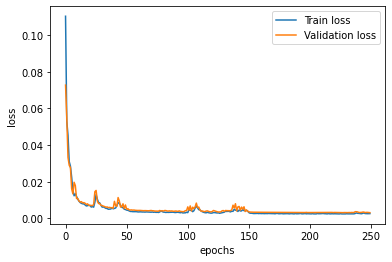

In [304]:
plt.plot(train_loss, label = 'Train loss')
plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

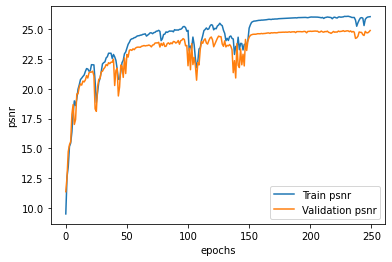

In [305]:
plt.plot(train_psnr, label = 'Train psnr')
plt.plot(val_psnr, label = 'Validation psnr')
plt.xlabel('epochs')
plt.ylabel('psnr')
plt.legend()
plt.show()

convert LR images to HR images: 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


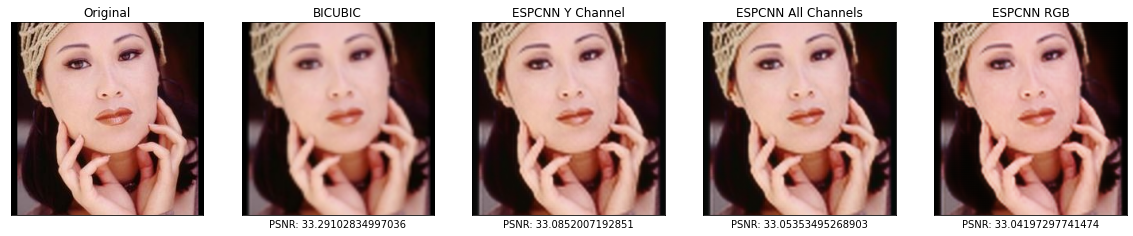

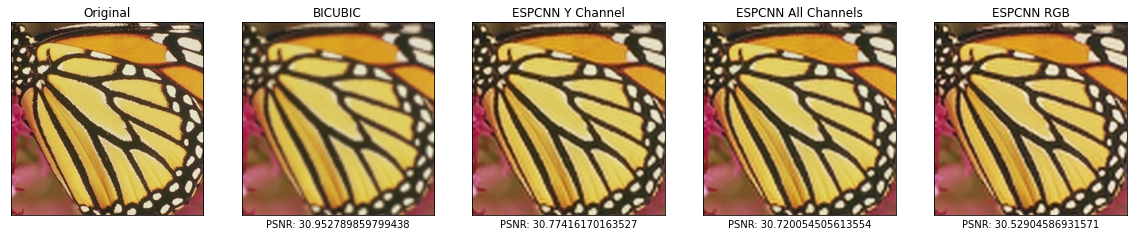

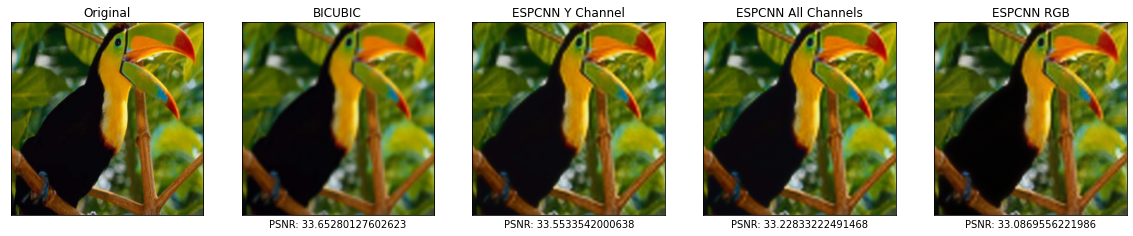

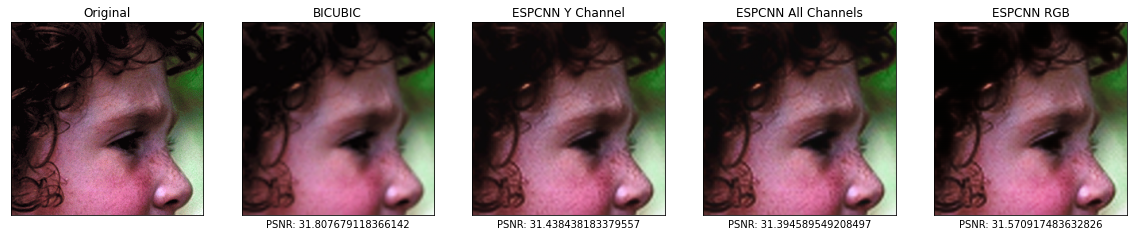

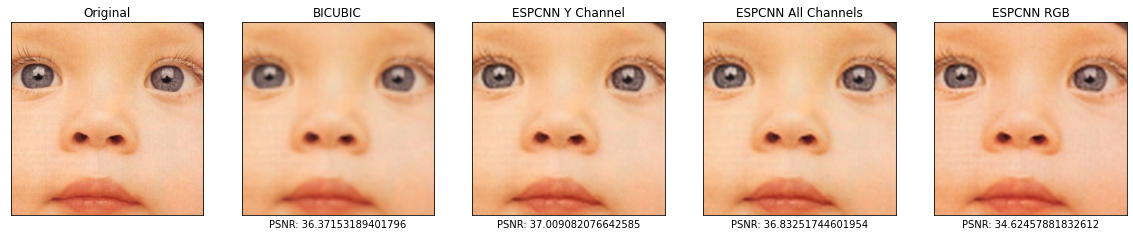

In [306]:
path = 'data/Test/Set5/SRF_' + str(UPSCALE_FACTOR) + '/data/'
images_name = [x for x in listdir(path) if is_image_file(x)]

out_path = 'results/SRF_' + str(UPSCALE_FACTOR) + '/'

meter_psnr = PSNRMeterImage()

if not os.path.exists(out_path):
    os.makedirs(out_path)
for image_name in tqdm(images_name, desc='convert LR images to HR images'):

    ref = Image.open('data/Test/Set5/SRF_' + str(UPSCALE_FACTOR) + '/target/' + image_name)
    img = Image.open(path + image_name).convert('YCbCr')
    img_rgb = Image.open(path + image_name).convert('RGB')
    #print(np.array(img_rgb))
    img_rgb = Variable(transforms.ToTensor()(img_rgb)).view(1, -1, img_rgb.size[0], img_rgb.size[1])
    #print(img_rgb.shape)
    #print(img_rgb)
    #plt.imshow(img_rgb)
    if torch.cuda.is_available():
        img_rgb = img_rgb.cuda()
    out_rgb = model_RGB(img_rgb).data[0].numpy()
    out_rgb *= 255.999
    out_rgb = out_rgb.clip(0, 255)
    #print(out_rgb.shape)
    #print(out_rgb)
    out_rgb = np.dstack((out_rgb[0], out_rgb[1], out_rgb[2]))
    out_rgb = Image.fromarray(np.uint8(out_rgb), 'RGB')
    meter_psnr.add(np.array(out_rgb.crop((6,6,w - 6, h - 6))), np.array(ref.crop((6,6,w - 6, h - 6))))
    psnr_RGB = meter_psnr.value()
    meter_psnr.reset()
    y, cb, cr = img.split()
    image = Variable(transforms.ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
    if torch.cuda.is_available():
        image = image.cuda()
    out = model_Y(image)
    out = out.cpu()
    out_img_y = out.data[0].numpy()
    out_img_y *= 255.999
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    out_img.save(out_path + image_name)
    meter_psnr.add(np.array(out_img.crop((6,6,w - 6, h - 6))), np.array(ref.crop((6,6,w - 6, h - 6))))
    psnr_ESPCN = meter_psnr.value()
    meter_psnr.reset()
    image = Variable(transforms.ToTensor()(cb)).view(1, -1, y.size[1], y.size[0])
    if torch.cuda.is_available():
        image = image.cuda()
    cb_out = model_Cb(image)
    image = Variable(transforms.ToTensor()(cr)).view(1, -1, y.size[1], y.size[0])
    if torch.cuda.is_available():
        image = image.cuda()
    cr_out = model_Cr(image)
    out_img_cb = cb_out.data[0].numpy()
    out_img_cb *= 255.999
    out_img_cb = out_img_cb.clip(0, 255)
    out_img_cb = Image.fromarray(np.uint8(out_img_cb[0]))
    out_img_cr = cr_out.data[0].numpy()
    out_img_cr *= 255.999
    out_img_cr = out_img_cr.clip(0, 255)
    out_img_cr = Image.fromarray(np.uint8(out_img_cr[0]))
    sup = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    meter_psnr.add(np.array(sup.crop((6,6,w - 6, h - 6))), np.array(ref.crop((6,6,w - 6, h - 6))))
    psnr_ESPCN_ALL = meter_psnr.value()
    meter_psnr.reset()
    meter_psnr.add(np.array(img.convert('RGB').resize((img.width * 3, img.height * 3), resample = Image.BICUBIC).crop((6,6,w-6,h-6))), np.array(ref.crop((6,6,w - 6, h - 6))))
    psnr_BICUBIC = meter_psnr.value()
    meter_psnr.reset()
    
    w = ref.width
    h = ref.height
    fig, axs = plt.subplots(1, 5, figsize=(20, 8))
    axs[0].imshow(ref.crop((6,6,w - 6, h - 6)))
    axs[0].set_title('Original')
    axs[1].imshow(img.convert('RGB').resize((img.width * 3, img.height * 3), resample = Image.BICUBIC).crop((6,6,w-6,h-6)))
    axs[1].set_title('BICUBIC')
    axs[1].set(xlabel = 'PSNR: {}'.format(psnr_BICUBIC))
    axs[2].imshow(out_img.crop((6,6,w - 6,h - 6)))
    axs[2].set_title('ESPCNN Y Channel')
    axs[2].set(xlabel = 'PSNR: {}'.format(psnr_ESPCN))
    axs[3].imshow(sup.crop((6,6,w-6,h-6)))
    axs[3].set_title('ESPCNN All Channels')
    axs[3].set(xlabel = 'PSNR: {}'.format(psnr_ESPCN_ALL))
    axs[4].imshow(out_rgb.crop((6,6,w-6,h-6)))
    axs[4].set_title('ESPCNN RGB')
    axs[4].set(xlabel = 'PSNR: {}'.format(psnr_RGB))

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
               
      
    #print('Saving {}'.format(file))
    #fig.savefig('Output/{}.png'.format(os.path.splitext(file)[0])) 
    #plt.close()